# **Inferencia Estadística**
# IE05.1. Modelo de simulación estocástica discreta

## <font color='blue'>__Bibliografía__</font>

* Simulation Modelling and Analysis. Averill M. Law, W.David Kelton, 2000.

## <font color='blue'>__Lecturas__</font>

* Framework SimPy https://simpy.readthedocs.io/en/latest/
* Simulación discreta https://en.wikipedia.org/wiki/Discrete-event_simulation
* Simulación de un call center: https://github.com/robertomoragad/Estadistica/blob/master/Sim_call_center_0_2.ipynb


<img src="https://drive.google.com/uc?export=view&id=1Igtn9UXg6NGeRWsqh4hefQUjV0hmzlBv" width="100" align="left" title="Runa-perth">
<br clear="left">
Contenido opcional

##<font color='blue'>**Introducción**</font>

En el presente notebook vamos a compartir un modelo de simulación discreta que he desarrollado para representar la operación de un centro de ayuda, al cual le llamaremos **Help Desk**.

El modelo es muy sencillo y puede ser ajustado para adaptarse perfectamente a otras realidades de procesos, servicios y negocios, como:

* centro de atención de clientes
* unidad de venta y activación de productos/servicios
* equipos de desarrollo y explotación de software
* atención médica / urgencias
* línea de ensamble
* otros.

Una vez creado el modelo con la ayuda de python y el framework **SimPy**, procederemos a correr simulaciones de un escenario actual, con el propósito de conocer el rendimiento inicial del sistema Help Desk.  Luego procederemos a desarrollar distintos experimentos con el objetivo de buscar un escenario que satisfaga las necesidades de negocio que serán planteadas. Para tal efecto aplicaremos análisis estadístico que nos permita determinar la mejor solución.

**¿Qué es una simulación?**

Es una representación de un sistema del mundo real. Podemos usar modelos matemáticos o computacionales para estudiar cómo funciona un sistema, o qué sucede cuando se cambian partes de el.
Las simulaciones se utilizan en centros de antención, bancos, restaurantes, aeropuertos, mecánicos, hospitales y muchos otros sistemas donde la mala asignación de recursos y aqruitecturas de procesos y métodos, puede provocar congestión, insatisfacción del cliente y retrasos críticos con impacto en las personas y resultados de negocio.

##<font color='blue'>**Procedemos a instalar SimPy y cargar las librerías**</font>

**¿Qué es SimPy?**:
Es un framework de simulación de eventos discretos basado en procesos, que está basado en Python estándar. SimPy se lanza como software de código abierto bajo la licencia MIT. La primera versión fue lanzada en diciembre de 2002.

In [1]:
pip install simpy

In [2]:
# Cargamos librerías
import random
import simpy
import numpy as np
import scipy.stats as stats
from time import time
from tqdm.notebook import trange # Barra de estado
import matplotlib.pyplot as plt

## <font color='blue'>**Modelamiento del Help Desk**</font>

Vamos a imaginar que trabajamos en un HelpDesk que tiene la misión de atender requerimientos de clientes.

El servicio que vamos a modelar tiene la siguiente estructura secuencial de procesos:

<br>
$$\text{Creación de Requerimiento} \rightarrow \text{Proceso 1} \rightarrow \text{Proceso 2} \rightarrow \text{Fin}$$
<br><br>
<img src='https://drive.google.com/uc?export=view&id=1e9jwE0J6HzWqZRhkSpm4vOD2EcII4pBh' width="1000" align="center" style="margin-right: 20px">
<br>


<p style="font-size:8pt">
Imagen gentileza de: Roberto Moraga</p>



###<font color='blue'>**Creación de Requerimiento**</font>

Por una parte tenemos clientes, quienes son los que crean tickets para solicitar una atención, a esto le llamaremos Requerimiento.

Para considerar la variabilidad a este proceso de arribo de Requerimientos al sistema Help Desk, hemos estudiado la cantidad promedio de tickets que se crean por hora (durante el último mes) y esto nos da una media de 15.0 Tickets creados por hora (este parámetro se llama lambda en una __distribución Poisson__).

$$\lambda = 15.0 \;\text{(ticket / hora)} = 0.25 \;\text{(ticket / minuto)}$$

Con este parámetro calcularemos el tiempo promedio entre llegadas de tickets al sistema, lo que nos da una media en minutos igual a 4.0 (minutos/ticket), es decir, en promedio un ticket arriba al sistema Help Desk cada 4 minutos. Incorporaremos una __distribución exponencial__ a esta variable, tal como se aprecia en la imagen superior.

$$ 1/\lambda = 1 / 0.25  = 4.0 \;\text{(minutos/ticket)}$$

Una vez creado el ticket (Requerimiento) este es depositado en un Backlog (cola) único, al cual le llamaremos **Backlog #1**. En este lugar los tickets esperan hasta que exista disponibilidad de un Agente del __Proceso #1__ para ser atendido.



###<font color='blue'>**Proceso N°1**</font>

Este proceso corresponde a la primera parte del trabajo que debe ser desarrollado para atender y resolver por completo el Requerimiento.

Este proceso es ejecutado por __Agentes de proceso #1__, ellas son personas especializadas en esta etapa del servicio. Actualmente el sistema cuenta con 2 __Agentes de Proceso #1__.

Para incorporar la variabilidad que existe en este __Proceso #1__, hemos estudiado el tiempo de ciclo de este proceso, el cual sigue una distribución Gamma, tal como se muestra en la imagen superior. Este proceso tiene una media de 17.9 minutos de duración.

Una vez finalizada esta parte del servicio, el ticket queda en un segundo backlog único, al cual le llamaremos **Backlog #2**.  En este lugar los tickets esperan hasta que exista disponibilidad de un __Agente del Proceso #2__ para ser atendido y finalizar por completo el trabajo requerido por los clientes.

###<font color='blue'>**Proceso N°2**</font>

Este proceso corresponde a la segunda y última parte del trabajo que debe ser desarrollado para resolver por completo el Requerimiento.

Este proceso es ejecutado por __Agentes de proceso #2__, ellas son personas especializadas en esta etapa del servicio. Actualmente el sistema cuenta con 2 __Agentes de Proceso #2__.

Para incorporar la variabilidad que existe en este __Proceso #2__, hemos estudiado el tiempo de ciclo de este proceso, el cual sigue una distribución Gamma, tal como se muestra en la imagen superior. Este proceso tiene una media de 24.5 minutos de duración.

Una vez finalizada esta parte del servicio, el ticket queda resuelto y así se finaliza por completo el Requerimiento del cliente.



###<font color='blue'>**Simulación y Respuestas**</font>

El escenario que será simulado corresponde a la situación inicial del Help Desk. Este escenario cuenta con los siguientes parámetros:

* Tasa de creación tickets: $\lambda$ = 15 (ticket/hora)
* Tiempo entre creación de tickets sigue distribución Exponencial con:
  * $1/ \lambda$ = 4 minutos
* Tiempo de proceso #1 sigue distribución Gamma con
  * $\alpha$ = 9.0
  * $\beta$ = 2.0
* Tiempo de proceso #2 sigue distribución Gamma con
  * $\alpha$ = 7.0
  * $\beta$ = 3.5
* Cantidad Agentes proceso N°1:   2 personas
* Cantidad Agentes proceso N°2:   2 personas

El tiempo de simulación será de 8 horas, ya que se necesita evaluar el rendimiento de un día de trabajo en el Help Desk.

> 1 día laboral = 8 horas cronológicas

Las respuestas del sistema que serán medidas son:
* Cantidad de tickets creados en un día laboral
* Cantidad de tickets resueltos en un día laboral
* Nivel de atención de un día laboral. Correponde a la proporción de los tickets que fueron resueltos del total de tickets creados.
* Leadtime end to end de un día laboral. Corresponde al tiempo promedio de duración de un ticket, desde que es creado por cliente hasta que este es resuelto.


## <font color='blue'>**Pequeñas consideraciones previas**</font>
El simulador opera en base a funciones generadoras, las cuales entregan un resultado (una llamada, una llegada de un cliente, una atención finalizada, etc.) en base a los tiempos generados de forma aleatoria por una distribución de probabilidad específica. Veamos un ejemplo:

In [3]:
# Se define una semilla en Numpy la cual define el punto de partida de la secuencia pseudoaleatoria
# Todos los objetos de scipy.stats operan con la semilla de Numpy
np.random.seed(22)

# En la simulación definimos funciones generadoras
def g(alpha, beta):
    """
    Devuelve un número aleatorio para una función gamma con parámetros alpha y beta
    """
    while True:
        yield stats.gamma.rvs(alpha, beta, 1)

In [4]:
alpha = 9
beta = 2
# Instanciamos el generador
a = g(alpha, 1/beta)

In [5]:
# Ejecutar varias veces
b = next(a)
b

np.float64(8.898781914039947)

Para generar números aleatorios, se pueden utilizar distintas librerías, e.g., `Numpy`, `random`, o `scipy.stats`. En todos los casos hay que cuidar la correcta parametrización.

In [6]:
# Generemos aleatorios para una Gamma(9,2)
# Primero con random.gammavariate

muestra_g1 = []
for i in range(1000):
    muestra_g1.append(random.gammavariate(alpha, beta))

In [7]:
# Ahora con stats.gamma
gamma = stats.gamma(a=alpha, loc=0, scale=beta)
muestra_g2 = gamma.rvs(size=1000)

Media teórica de una Gamma(9,2)             : 18.0
Media muestra gamma con random.gammavariates: 18.15
Media muestra gamma con scipy.stats         : 17.99


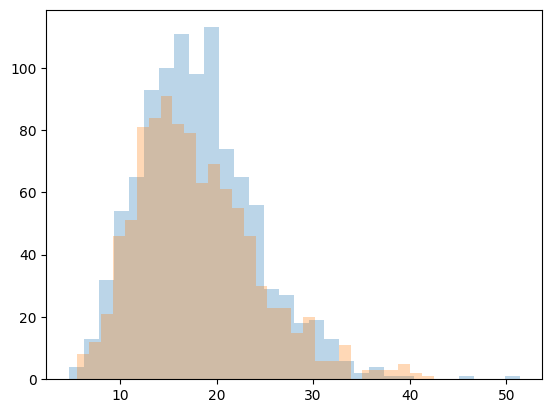

In [8]:
# Comparemos los resultados
print(f'Media teórica de una Gamma(9,2)             : {gamma.stats(moments="m")}')
print(f'Media muestra gamma con random.gammavariates: {np.mean(muestra_g1):4.2f}')
print(f'Media muestra gamma con scipy.stats         : {np.mean(muestra_g2):4.2f}')
plt.hist(muestra_g1, 30, alpha=0.3)
plt.hist(muestra_g2, 30, alpha=0.3)
plt.show()

## <font color='blue'>**Creación del modelo en python con SimPy**</font>

A continuación encontrarás el código que se ha desarrollado para simular el Help Desk propuesto.

In [9]:
# Inicio

# Creamos parámetros del modelo:
NUM_EMPLOYEES_1 = 2  # Número de agentes en el proceso #1 del ciclo de trabajo
NUM_EMPLOYEES_2 = 2  # Número de agentes en el proceso #2 del ciclo de trabajo

# Tiempos de los 2 procesos secuenciales con distribution Gamma
# proceso #1
alpha_1= 9.0
beta_1= 2.0
# proceso #2
alpha_2 = 7.00
beta_2= 3.50

SUPPORT_TIME_1 = alpha_1 * beta_1   # Minutos promedio para el trabajo del proceso #1
SUPPORT_TIME_2 = alpha_2 * beta_2   # Minutos promedio para el trabajo del proceso #2
AVG_CUSTOMER_HOUR = 15              # en promedio llegan X tickets por hora al backlog
                                    # del HelpDesk (esto es el lambda de poisson)
CUSTOMER_INTERVAL = 60/AVG_CUSTOMER_HOUR # Crea un cliente cada X minutos
SIM_TIME = 60 * 8                     # tiempo de simulación en minutos

customers_handled = 0

# Un Help Desk tiene un número limitado de agentes (empleados) para atender requerimientos de clientes
# El ciclo de vida del Requerimiento consta de 2 procesos (etapas) secuenciales (proceso #1 y proceso #2)
# Los clientes crean un Requerimiento, este ingresa a un Backlog donde debe esperar a uno de los agentes del primer proceso
# Cuando un Requerimiento consigue disponibilidad de un agente del primer proceso, comienza a ser atendido requerimiento hasta que finaliza el proceso #1
# Una vez finalizada la parte del primer proceso, el requerimiento entra al backlog del segundo proceso
# Cuando un Requerimiento consigue disponibilidad de un agente del segundo proceso, comienza a ser atendido hasta que finaliza el proceso #2 y allí finaliza la atención

class HelpDesk(object):
    def __init__(self, env, num_employees_1, num_employees_2,
                 support_time_1, support_time_2,
                 alpha_1=alpha_1, beta_1=beta_1,
                 alpha_2=alpha_2, beta_2=beta_2,
                 verbose=False):
        self.env = env
        self.staff_1 = simpy.Resource(env, num_employees_1)
        self.staff_2 = simpy.Resource(env, num_employees_2)
        self.support_time_1 = support_time_1
        self.support_time_2 = support_time_2
        self.alpha_1 = alpha_1
        self.beta_1 = beta_1
        self.alpha_2 = alpha_2
        self.beta_2 = beta_2
        self.dist_1 = stats.gamma(a=self.alpha_1, loc=0, scale=self.beta_1)
        self.dist_2 = stats.gamma(a=self.alpha_2, loc=0, scale=self.beta_2)
        self.verbose = verbose

    def support_1(self, customer):
        # El proceso #1 trabaja en la primera parte del Requerimiento
        random_time_1 = self.dist_1.rvs(1)[0]
        #random_time_1 = random.gammavariate(self.alpha, self.beta)
        if self.verbose: print(f"*  Proceso #1 finalizado para Cliente {customer} a las {self.env.now:.2f}")
        yield self.env.timeout(random_time_1)

    def support_2(self, customer):
        # El proceso #2 trabaja en la segunda parte del Requerimiento
        random_time_2 = self.dist_2.rvs(1)[0]
        #random_time_2 = random.gammavariate(self.alpha, self.beta)
        if self.verbose: print(f"** Proceso #2 finalizado para Cliente {customer} a las {self.env.now:.2f}")
        yield self.env.timeout(random_time_2)

def customer(env, name, help_desk, verbose):
    # Los clientes (cada cliente tiene un nombre) crean Requerimientos en el Help Desk y para ser resueltos por agentes
    # Luego los Requerimiento de clientes comienzan a ser atendidos por un Agente del proceso #1, esperan hasta
    # que finaliza la la primera parte del trabajo del proceso #1, luego el requerimiento ingresa al backlog del proceso #2
    # El Requerimiento comienza a ser atendido por un Agente del proceso #2, los clientes esperan hasta que finaliza la segunda parte
    # del trabajo del proceso #2, y luego el Requerimiento finaliza por completo, saliendo del Help Desk (para no volver de nuevo..)

    arrival_time = env.now # guarda el minuto de creación del Requerimiento del cliente
    arrival_times.append(arrival_time) # calcula el tiempo en que ingresa ticket al backlog
    global customers_handled
    if verbose: print(f"Cliente {name} ingresa requerimiento al Backlog #1 a las {env.now:.2f}")
    with help_desk.staff_1.request() as request:
        yield request
        # Cliente se dirije a ser atendido por un primer agente
        if verbose: print(f"Cliente {name} comienza a ser atendido su requerimiento por el proceso #1 a las {env.now:.2f}")
        start_support_time_1 = env.now # guarda el minuto en que se inicia la atención del cliente
        wait_times_1.append(env.now - arrival_time) #c alcula el tiempo de espera en la cola 1

        yield env.process(help_desk.support_1(name))
        # Cliente sale del primer proceso
        if verbose: print(f"Cliente {name} su requerimiento finaliza el proceso #1 a las {env.now:.2f}")
        support_times_1.append(env.now - start_support_time_1) #calcula el tiempo de atención del proceso #1

    if verbose: print(f"Cliente {name} su requerimiento ingresa al Backlog #2 a las {env.now:.2f}!")
    with help_desk.staff_2.request() as request:
        yield request
        # Cliente se dirije a ser atendido por un segundo agente
        start_support_time_2 = env.now # guarda el minuto en que se inicia la atención del cliente
        if verbose: print(f"Cliente {name} comienza a ser atendido su requerimiento por el proceso #2 a las {start_support_time_2:.2f}")

        yield env.process(help_desk.support_2(name))
        # Cliente sale del segundo proceso y finaliza la atención
        if verbose: print(f"Cliente {name} su requerimiento finaliza el proceso #2 y se cierra ticket a las {env.now:.2f}")
        customers_handled += 1
        support_times_2.append(env.now - start_support_time_2) # calcula el tiempo de atención del proceso #2
        total_times.append(env.now - arrival_time) # calcula el tiempo total (todo el proceso de atención)

def setup(env, num_employees_1, num_employees_2, support_time_1, support_time_2, customer_interval, verbose=False):
    """
    Crea un Help Desk, un número inicial de clientes y luego se mantendrá
    creando clientes cada "CUSTOMER_INTERVAL" minutos
    """
    # Crea una instancia del Help Desk
    help_desk = HelpDesk(env, num_employees_1, num_employees_2, support_time_1, support_time_2, verbose=verbose)

    # Crea 5 clientes iniciales
    for i in range(1, 2):
        env.process(customer(env, i, help_desk, verbose=verbose))

    # Crea más clientes mientras la simulación está corriendo
    while True:
        yield env.timeout(stats.expon.rvs(loc=0, scale=(customer_interval), size=1)[0])
        i += 1
        env.process(customer(env, i, help_desk, verbose=verbose))

## <font color='blue'>**Ejecución de una corrida**</font>
En esta ejecución activaremos las salidas impresas (`verbose=True`) de a simulación.

In [10]:
# Setup e inicio de la simulación
print("Iniciando la simulación del Call Center \n")

# Crear listas para almacenar datasets y su posterior análisis de resultados
arrival_times = []   # corresponde al tiempo en que ingresa al Backlog el requerimiento
wait_times_1 = []    # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que lo comienza a trabajar un agente del proceso #1
wait_times_2 = []    # corresponde al tiempo transcurrido desde que el agente del proceso #1 finaliza su parte, hasta el agente del proceso #2 comienza su etapa del trabajo
support_times_1 = [] # corresponde al tiempo transcurrido desde que agente del proceso #1 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
support_times_2 = [] # corresponde al tiempo transcurrido desde que agente del proceso #2 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
total_times = []     # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que es completamente resuelto

RANDOM_SEED = 2 # fijar una semilla para correr 1 replica reproducible

t0 = time()
print(f"Se inicia la Simulación del Help Desk - por {SIM_TIME} minutos")
#random.seed(RANDOM_SEED)  #esto nos ayudará a reproducir los resultados
np.random.seed(seed=RANDOM_SEED) # Aplica la semilla para los objetos de scipy.stats

# Crea el entorno de simulación e inicia el proceso setup
env = simpy.Environment()
env.process(setup(env, NUM_EMPLOYEES_1, NUM_EMPLOYEES_2, SUPPORT_TIME_1, SUPPORT_TIME_2, CUSTOMER_INTERVAL, verbose=True))

# Ejecuta!
env.run(until=SIM_TIME)

print(f"\nClientes atendidos: {customers_handled}")
print(f"\nTiempo total de simulación: {(time() - t0):6.4f} segundos")

Iniciando la simulación del Call Center 

Se inicia la Simulación del Help Desk - por 480 minutos
Cliente 1 ingresa requerimiento al Backlog #1 a las 0.00
Cliente 1 comienza a ser atendido su requerimiento por el proceso #1 a las 0.00
*  Proceso #1 finalizado para Cliente 1 a las 0.00
Cliente 2 ingresa requerimiento al Backlog #1 a las 2.29
Cliente 2 comienza a ser atendido su requerimiento por el proceso #1 a las 2.29
*  Proceso #1 finalizado para Cliente 2 a las 2.29
Cliente 3 ingresa requerimiento al Backlog #1 a las 4.47
Cliente 4 ingresa requerimiento al Backlog #1 a las 5.39
Cliente 5 ingresa requerimiento al Backlog #1 a las 9.25
Cliente 6 ingresa requerimiento al Backlog #1 a las 10.68
Cliente 7 ingresa requerimiento al Backlog #1 a las 11.92
Cliente 8 ingresa requerimiento al Backlog #1 a las 15.80
Cliente 2 su requerimiento finaliza el proceso #1 a las 17.19
Cliente 2 su requerimiento ingresa al Backlog #2 a las 17.19!
Cliente 2 comienza a ser atendido su requerimiento por el

In [11]:
# Respuestas
NA = customers_handled / len(arrival_times) # Nivel de atención
print(f"Cantidad de tickets creados:   {len(arrival_times)}") # cantidad tickets creados
print(f"Cantidad de tickets resueltos: {customers_handled}") # cantidad tickets resueltos
print(f"Nivel de atención:             {NA:5.3f}") # Nivel atención
print(f"Leadtime:                      {np.mean(total_times):4.2f}") # leadtime

Cantidad de tickets creados:   127
Cantidad de tickets resueltos: 34
Nivel de atención:             0.268
Leadtime:                      199.78


## <font color='blue'>**Análisis de resultados**</font>

Luego de correr un día laboral, es decir, una réplica del modelo durante 8 horas, los resultados que vemos son:

* Cantidad de tickets creados en un día laboral = **127**
* Cantidad de tickets resueltos en un día laboral = **34**
* Nivel de atención de un día laboral = **26.8%**
* Leadtime end to end de un día laboral = **199.78** minutos

Los datos anteriores son valores agregados del día laboral simulado, por tanto esconden el detalle. Por ejemplo si quisiéramos conocer la distribución completa de los tiempos totales de atención (que en promedio nos da un leadtime de 199.78 min) tenemos que tomar la lista creada donde está el registro de cada ticket resuelto con su tiempo total de atención.

En el siguiente gráfico podremos apreciar todo este detalle de los tiempos totales de atención:

Leadtime: 199.784 minutos


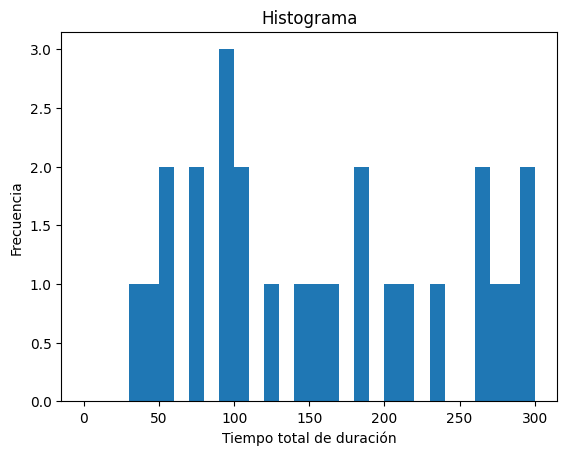

In [ ]:
# Graficar histograma de tiempos totales de atención

print(f'Leadtime: {np.mean(total_times):5.3f} minutos')

plt.hist(total_times, bins=30, range=(0, 300))
plt.ylabel('Frecuencia')
plt.xlabel('Tiempo total de duración')
plt.title('Histograma')
plt.show()

Como podemos ver, nuestro modelo, al considerar la aleatoriedad de los factores incorporados en el modelo, nos permite simular situaciones más realistas, las cuales tienen una infinidad de factores que condicionan su no-linealidad. Por esta razón podemos ver tickets con tiempos totales muy bajos cercanos a 25 minutos, y otros extremos por la derecha cercanos a los 300 minutos. Por esta razón los modelos lineales basados en valores promedios y constantes, entregan resultados que normalmente subestiman la realidad.

En el siguiente gráfico he creado un run chart para ver cómo evolucionan los tiempos totales de los tickets. Claramente podemos ver la tendencia al alza, lo que es muy preocupante, ya que nos indica que si la jornada tuviera más de 8 horas, los tiempos seguirían subiendo, y con ello el Leadtime. Claramente este sistema de trabajo se encuentra desbalanceado.



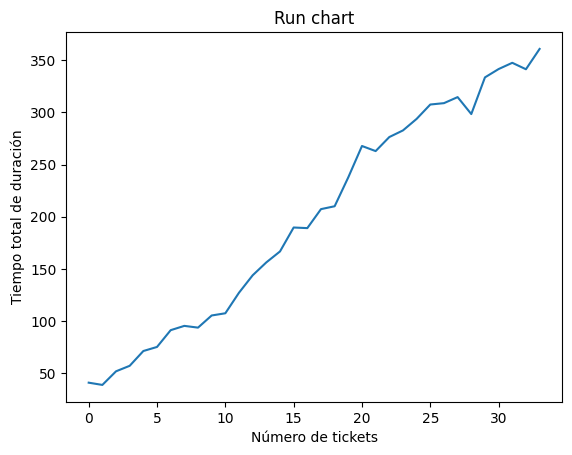

In [ ]:
# Graficar run chart
plt.plot(total_times)
plt.ylabel('Tiempo total de duración')
plt.xlabel('Número de tickets')
plt.title('Run chart')
plt.show()

Recordemos que la simulación corrida anteriormente fue solo una, y como estamos en la presencia de un modelo probabilístico, tener solo una réplica para análisis y toma de decisiones, es muy riesgoso. La solución sugerida aquí es correr varias simulaciones, un buen número es 30 o más (regla de pulgar), y con sus respuestas construir histogramas y calcular intervalos, que nos entreguen mayor confiabilidad de los resultados obtenidos.

A continuación presentaremos en el análisis de resultados luego de correr 300 veces el modelo de situación inicial. Recordemos que el modelo inicial cuenta con 2 agentes en __Proceso #1__ y otros 2 agentes en el __Proceso #2__, por tanto en total tiene 4 agentes nuestro Help Desk.


## <font color='blue'>**Simulación de $n$ corrdidas**</font>
Realizaremos una simulación de $n=300$ corridas. Esta vez desactivaremos el `verbose` para acelerar el proceso.

In [ ]:
# Setup e inicio de la simulación con n corridas
print("Iniciando la simulación del Help Desk \n")

# Definimos listas vacias para almacenar las listas de resultados de cada corrida
tch = []  # Customes Handled
tat = []  # Arrival times
tNA = []  # Número de Atenciones
tLT = []  # Leadtime
tST = []  # Support time
tTT = []  # Tiempo total

# Número de corridas
corridas = 300

t0 = time()
tc = t0
print(f"Se realizan {corridas} corridas de {SIM_TIME} minutos cada una")

np.random.seed(seed=RANDOM_SEED) # Aplica la semilla para los objetos de scipy.stats

for c in trange(corridas):
    # Cada corrida individual, inicializa sus estructuras de captura de datos
    customers_handled = 0
    arrival_times = []   # corresponde al tiempo en que ingresa al Backlog el requerimiento
    wait_times_1 = []    # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que lo comienza a trabajar un agente del proceso #1
    wait_times_2 = []    # corresponde al tiempo transcurrido desde que el agente del proceso #1 finaliza su parte, hasta el agente del proceso #2 comienza su etapa del trabajo
    support_times_1 = [] # corresponde al tiempo transcurrido desde que agente del proceso #1 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    support_times_2 = [] # corresponde al tiempo transcurrido desde que agente del proceso #2 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    total_times = []     # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que es completamente resuelto

    print(f"\nSIMULACION {c}")
    # Crea el entorno de simulación e inicia el proceso setup
    env = simpy.Environment()
    env.process(setup(env, NUM_EMPLOYEES_1, NUM_EMPLOYEES_2, SUPPORT_TIME_1, SUPPORT_TIME_2, CUSTOMER_INTERVAL, verbose=False))

    # Ejecuta!
    env.run(until=SIM_TIME)

    print(f"\nClientes atendidos:            {customers_handled}")

    # Respuestas
    NA = customers_handled / len(arrival_times) # Nivel de atención
    print(f"Cantidad de tickets creados:   {len(arrival_times)}") # cantidad tickets creados
    print(f"Cantidad de tickets resueltos: {customers_handled}") # cantidad tickets resueltos
    print(f"Nivel de atención:             {NA:6.4f}") # Nivel atención
    print(f"Leadtime:                      {np.mean(total_times):4.2f}") # leadtime
    tch.append(customers_handled)
    tat.append(arrival_times)
    tNA.append(NA)
    tLT.append(np.mean(total_times))
    tTT.append(total_times)
    print(f"\nTiempo total de simulación {c}: {(time() - tc):4.2f} segundos")
    tc = time()
print(f"\nTiempo total de simulación: {(time() - t0):4.2f} segundos")

Iniciando la simulación del Help Desk 

Se realizan 300 corridas de 480 minutos cada una


  0%|          | 0/300 [00:00<?, ?it/s]


SIMULACION 0

Clientes atendidos:            34
Cantidad de tickets creados:   127
Cantidad de tickets resueltos: 34
Nivel de atención:             0.2677
Leadtime:                      199.78

Tiempo total de simulación 0: 0.08 segundos

SIMULACION 1

Clientes atendidos:            34
Cantidad de tickets creados:   119
Cantidad de tickets resueltos: 34
Nivel de atención:             0.2857
Leadtime:                      210.69

Tiempo total de simulación 1: 0.01 segundos

SIMULACION 2

Clientes atendidos:            41
Cantidad de tickets creados:   129
Cantidad de tickets resueltos: 41
Nivel de atención:             0.3178
Leadtime:                      193.61

Tiempo total de simulación 2: 0.02 segundos

SIMULACION 3

Clientes atendidos:            36
Cantidad de tickets creados:   118
Cantidad de tickets resueltos: 36
Nivel de atención:             0.3051
Leadtime:                      199.19

Tiempo total de simulación 3: 0.01 segundos

SIMULACION 4

Clientes atendidos:          

## <font color='blue'>**Análisis de Resultados Modelo situación inicial con 4 agentes (2 + 2)**</font>

* Cantidad agentes en proceso N° 1 = **2**
* Cantidad agentes en proceso N° 2 = **2**

####Cantidad de tickets creados en un día laboral

Media               : 121.017
Mediana             : 120.000
Desviación estándar : 10.756
Con un 0.9 de Nivel de confianza el intervalo está entre: 103.32 y 138.71
Con un 0.9 de Nivel de confianza el intervalo está entre: 103.00 y 139.00


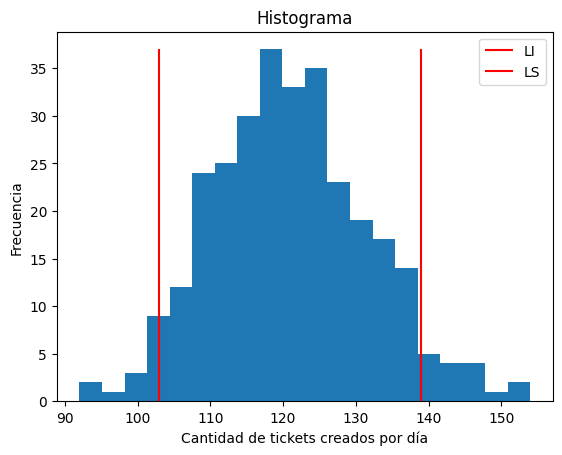

In [ ]:
# Lista tat "cantidad de tickets creados" luego de las 300 réplicas

q_creados_2_2 = [len(i) for i in tat]
print(f'Media               : {np.mean(q_creados_2_2):5.3f}')
print(f'Mediana             : {np.median(q_creados_2_2):5.3f}')
print(f'Desviación estándar : {np.std(q_creados_2_2):5.3f}')

# cálculo intervalos
# aplicando Normal
alpha = 0.10
NC = 1 - alpha # nivel de confianza
Z = stats.norm.ppf(1-(alpha)/2)
LI = np.mean(q_creados_2_2) - ( Z * np.std(q_creados_2_2))
LS = np.mean(q_creados_2_2) + ( Z * np.std(q_creados_2_2))
print(f"Con un {NC} de Nivel de confianza el intervalo está entre: {LI:6.2f} y {LS:6.2f}")
# aplicando Poisson (dado que es una variable discreta)
LI_p = stats.poisson(np.mean(q_creados_2_2)).ppf(alpha/2)
LS_p = stats.poisson(np.mean(q_creados_2_2)).ppf(1-alpha/2)
print(f"Con un {NC} de Nivel de confianza el intervalo está entre: {LI_p:6.2f} y {LS_p:6.2f}")

# graficando
f, b, i = plt.hist(q_creados_2_2, bins=20)
plt.vlines(ymin=0, ymax=max(f), x=LI_p,  colors='r', label='LI')
plt.vlines(ymin=0, ymax=max(f), x=LS_p,  colors='r', label='LS')
plt.ylabel('Frecuencia')
plt.xlabel('Cantidad de tickets creados por día')
plt.title('Histograma')
plt.legend()
plt.show()


El análisis arrojó que en promedio un día laboral recibirá 121 tickets, y con una seguridad del 90% podemos concluir que la cantidad de tickets creados por día estará entre 103 y 138.

Recordemos que el lambda definido al inicio del modelamiento era de 15 tickets por hora, si hubiésemos modelado el Help Desk de forma determinística siempre tendríamos 120 tickets por día (8 horas x 15 ticket/hora). La probabilidad de que ocurra esta situación es cercana a un 36%, lo que hubiese generado análisis y conclusiones erróneas.



In [ ]:
# probabilidad de tener en un día 120 tickets
prob_120= stats.poisson(np.mean(q_creados_2_2)).pmf(120)
print(F"Probabilidad de tener en un día 120 tickets: {prob_120:6.4f}")

Probabilidad de tener en un día 120 tickets: 0.0362


####Cantidad de tickets resueltos en un día laboral

Media               : 36.753
Mediana             : 37.000
Desviación estándar : 2.383
Con un 0.9 de Nivel de confianza el intervalo está entre:  32.83 y  40.67


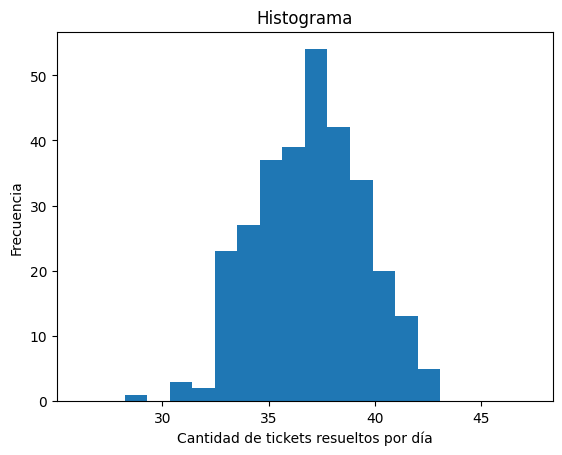

29
43


In [ ]:
# Lista tch "cantidad de tickets resueltos" luego de las 300 réplicas

q_resueltos_2_2 = tch
print(f'Media               : {np.mean(q_resueltos_2_2):5.3f}')
print(f'Mediana             : {np.median(q_resueltos_2_2):5.3f}')
print(f'Desviación estándar : {np.std(q_resueltos_2_2):5.3f}')

# calculo intervalos
# aplicando Normal
alpha = 0.10
NC = 1 - alpha # nivel de confianza
Z = stats.norm.ppf(1-(alpha)/2)
LI = np.mean(q_resueltos_2_2) - ( Z * np.std(q_resueltos_2_2))
LS = np.mean(q_resueltos_2_2) + ( Z * np.std(q_resueltos_2_2))
print(f"Con un {NC} de Nivel de confianza el intervalo está entre: {LI:6.2f} y {LS:6.2f}")

plt.hist(q_resueltos_2_2, bins=20, range=(min(q_resueltos_2_2)*0.9, max(q_resueltos_2_2)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Cantidad de tickets resueltos por día')
plt.title('Histograma')
plt.show()

#calculo de min y max
print(np.min(q_resueltos_2_2))
print(np.max(q_resueltos_2_2))

El análisis arrojó que en promedio en un día laboral se finalizarán/solucionarán 36 tickets, y con una seguridad del 90% podemos concluir que la cantidad de tickets resueltos por día estará entre 32 y 40.

####Nivel de atención de un día laboral

Media               : 0.306
Mediana             : 0.307
Desviación estándar : 0.032
Con un 0.9 de Nivel de confianza el intervalo está entre:   0.25 y   0.36


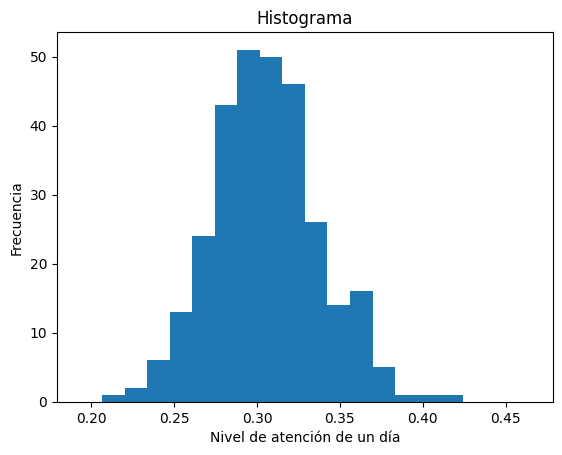

In [ ]:
# Lista tNA "nivel de atención" luego de las 300 réplicas

nivel_atencion_2_2 = tNA
print(f'Media               : {np.mean(nivel_atencion_2_2):5.3f}')
print(f'Mediana             : {np.median(nivel_atencion_2_2):5.3f}')
print(f'Desviación estándar : {np.std(nivel_atencion_2_2):5.3f}')

# Cálculo intervalos
# Aplicando Normal
alpha = 0.10
NC = 1 - alpha #nivel de confianza
Z = stats.norm.ppf(1-(alpha)/2)
LI = np.mean(nivel_atencion_2_2) - ( Z * np.std(nivel_atencion_2_2))
LS = np.mean(nivel_atencion_2_2) + ( Z * np.std(nivel_atencion_2_2))
print(f"Con un {NC} de Nivel de confianza el intervalo está entre: {LI:6.2f} y {LS:6.2f}")

plt.hist(nivel_atencion_2_2, bins=20, range=(min(nivel_atencion_2_2)*0.9, max(nivel_atencion_2_2)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Nivel de atención de un día')
plt.title('Histograma')
plt.show()

El análisis arrojó que en promedio en un día laboral se podrán resolver el 30.6% de los tickets recibidos, y con una seguridad del 90% podemos concluir que  el nivel de atención diario estará entre 25% y 36%.

####Leadtime end to end de un día laboral

Media               : 185.016
Mediana             : 184.414
Desviación estándar : 16.905
Con un 0.9 de Nivel de confianza el intervalo está entre: 157.21 y 212.82


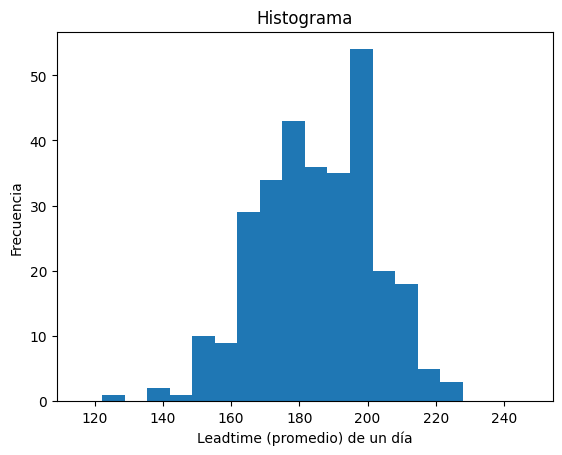

In [ ]:
# Lista tlt "leadtime" luego de las 300 replicas

leadtime_2_2 = tLT
print(f'Media               : {np.mean(leadtime_2_2):5.3f}')
print(f'Mediana             : {np.median(leadtime_2_2):5.3f}')
print(f'Desviación estándar : {np.std(leadtime_2_2):5.3f}')

# Cálculo intervalos
# Aplicando Normal
alpha = 0.10
NC = 1 - alpha # nivel de confianza
Z = stats.norm.ppf(1-(alpha)/2)
LI = np.mean(leadtime_2_2) - ( Z * np.std(leadtime_2_2))
LS = np.mean(leadtime_2_2) + ( Z * np.std(leadtime_2_2))
print(f"Con un {NC} de Nivel de confianza el intervalo está entre: {LI:6.2f} y {LS:6.2f}")

plt.hist(leadtime_2_2, bins=20, range=(min(leadtime_2_2)*0.9, max(leadtime_2_2)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Leadtime (promedio) de un día')
plt.title('Histograma')
plt.show()

El análisis arrojó que en promedio la media diaria de tiempos totales de atención (leadtime de un día laboral) es de 185 minutos, y con una seguridad del 90% podemos concluir que la media diaria de tiempos totales de atención (leadtime de un día laboral) estará entre 157 y 212 minutos.


Recordemos que el gráfico anterior nos muestra la distribución de las medias de un día laboral (8 horas) de los tiempos totales de atención de los tickets que si fueron resueltos, por tanto aquí tendremos cálculos de estas medias con muestras de entre 32 y 40 tickets (véase distribución de tickets resueltos). Por tanto este gráfico nos esconde el detalle de la distribución de los tiempos totales de los tickets, para ver este detalle a continuación presentaremos un histograma de estos tiempos en las réplicas corridas.

Media              : 184.74
Desviación estándar: 89.20


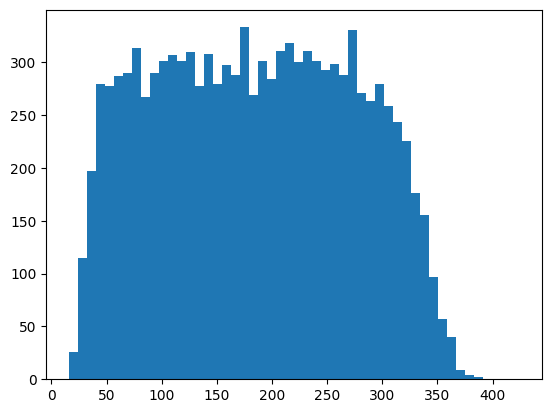

In [ ]:
# ANEXO
# Lista  tiempos totales (end to end) creado a partir los casos generados en 300 réplicas

tiempos_totales = [val for sublist in tTT for val in  sublist]
print(f"Media              : {np.mean(tiempos_totales):4.2f}")
print(f"Desviación estándar: {np.std(tiempos_totales):4.2f}")
plt.hist(tiempos_totales, bins=50, range=(min(tiempos_totales)*0.9, max(tiempos_totales)*1.1))
plt.show()

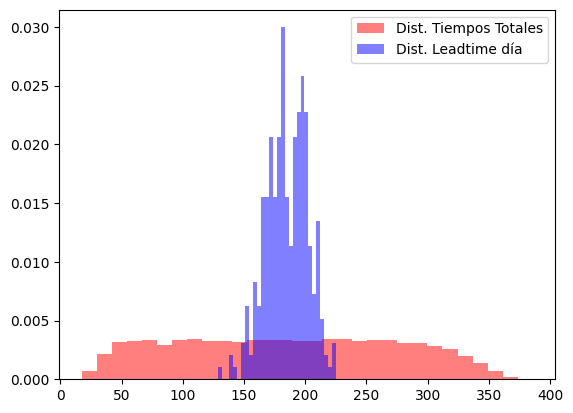

In [ ]:
plt.hist(tiempos_totales, bins=30, density=True, color='r', alpha=0.5, label="Dist. Tiempos Totales")
plt.hist(leadtime_2_2, bins=30, density=True, color='b', alpha=0.5, label="Dist. Leadtime día")
plt.legend()
plt.show()

Es evidente que la distribución de los tiempos totales de los tickets tiene mayor variabilidad que la de las medias diarias, además tiene una forma platicúrtica en comparación con las medias diarias (leadtime de un día laboral).

La explicación al fenómeno anterior la podemos encontrar en el Teorema del Límite Central (TLC), la que nos dice que independiente de la distribución que tenga la variable medida en los individuos objetos de estudio, si tomamos de esta población de individuos muestras grandes, y luego calculamos su media muestral, estás medias muestrales tendrán una distribución normal.

## <font color='blue'>**Desafío de negocio**</font>

Vamos a imaginar que el negocio y sus clientes se encuentran insatisfechos con los resultados que ha exhibido el Help Desk durante los último meses, esto porque los indicadores monitoreados no cumplen las expectativas planteadas al inicio de este servicio.

Los indicadores más relevantes para este servicio son 2:

1. Nivel de atención de un día laboral.
2. Leadtime end to end de un día laboral.

Ambos se encuentran fuera del target definido de > 85% para el primero y < 60 minutos para el segundo.

Actualmente el Help Desk tiene el siguiente rendimiento:

* Nivel de atención de un día laboral = 29%
* Leadtime end to end de un día laboral = 185 minutos ($\sigma= 86$ min)

Del Análisis de resultados del modelo inicial podemos apreciar que estos 2 indicadores (29% y 185 min), se encuentran contenido en el intervalo de confianza de 90%. Por tanto podemos concluir que el modelo predice de buena forma el rendimiento del sistema de trabajo.

Otra manera para validar si el modelo predice bien o tiene buen ajuste,  sería por medio de un test de hipótesis, planteado de la siguiente forma:

* $H_0$: El leadtime diario es igual a 185 minutos
* $H_1$: El leadtime diario es diferente a 185 minutos

Si la media de los 30 leadtime generados en las 30 réplicas, se situa entre los siguientes límites, caería en zona de no rechazo de $H_0$, de lo contario se rechazaría la $H_0$.

$$LI = 185 - 1.64* {\frac{86}{\sqrt{36}}} = 161.49 $$
$$LS = 185 + 1.64* {\frac{86}{\sqrt{36}}} = 208.50 $$

En este caso como la media de los 30 leadtime es 190.8 minutos cae en la zona de no rechazo, no podemos concluir que existe una diferencia, por tanto el modelo ajusta bien a la realidad.


>Nota 1: se trabaja con muestras de 36 tickets, ya que es el valor promedio de tickets creados/resueltos en un día.
>
>Nota 2: se trabaja con Z=1.64 para una prueba de 2 colas con alpha de 0.10.

Una vez validado el modelo, se procede a configurar distintos escenarios donde modificaremos los parámetros de control, en este caso solo ajustaremos:

* cantidad de agentes proceso N°1
* cantidad de agentes proceso N°2

De tal forma que haremos experimentos, cada uno con 30 réplicas, ajustando dichos parámetros hasta llegar a un escenario que nos permita cumplir las metas de negocio para el Nivel de atención y el Leadtime de un día laboral.

Estos escenarios pueden ser:

* Experimento 1:
 * Cantidad agentes en proceso N° 1 = **3**
 * Cantidad agentes en proceso N° 2 = **3**
* Experimento 2:
 * Cantidad agentes en proceso N° 1 = **4**
 * Cantidad agentes en proceso N° 2 = **4**
* Experimento 3:
 * Cantidad agentes en proceso N° 1 = **5**
 * Cantidad agentes en proceso N° 2 = **5**
* Experimento 4:
 * Cantidad agentes en proceso N° 1 = **6**
 * Cantidad agentes en proceso N° 2 = **6**


Luego de realizar todos los experimentos anteriores, es el experimento número 4 el que generó los mejores resultados, es decir, la distribución de los indicadores "nivel de atención diario" y "leadtime de un día laboral" se acercan a la meta trazada.

A continuación veamos en particular los resultados de este escenario:



### <font color='blue'>**Análisis de Resultados Modelo con 12 agentes (6 + 6)**</font>

* Cantidad agentes en proceso N° 1 = **6**
* Cantidad agentes en proceso N° 2 = **6**

In [ ]:
# Setup e inicio de la simulación con n corridas
print("Iniciando la simulación del Help Desk \n")

# Definimos listas vacias para almacenar la lista de resultados de cada corrida
tch = []
tat = []
tNA = []
tLT = []

# Número de corridas
corridas = 300

t0 = time()
tc = t0
print(f"Se realizan {corridas} corridas de {SIM_TIME} minutos cada una")

np.random.seed(seed=RANDOM_SEED) # Aplica la semilla para los objetos de scipy.stats

for c in trange(corridas):
    # Cada corrida individual, inicializa sus estructuras de captura de datos
    customers_handled = 0
    arrival_times = []   # corresponde al tiempo en que ingresa al Backlog el requerimiento
    wait_times_1 = []    # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que lo comienza a trabajar un agente del proceso #1
    wait_times_2 = []    # corresponde al tiempo transcurrido desde que el agente del proceso #1 finaliza su parte, hasta el agente del proceso #2 comienza su etapa del trabajo
    support_times_1 = [] # corresponde al tiempo transcurrido desde que agente del proceso #1 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    support_times_2 = [] # corresponde al tiempo transcurrido desde que agente del proceso #2 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    total_times = []     # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que es completamente resuelto

    print(f"\nSIMULACION {c}")

    NUM_EMPLOYEES_1 = 6
    NUM_EMPLOYEES_2 = 6

    # Crea el entorno de simulación e inicia el proceso setup
    env = simpy.Environment()
    env.process(setup(env, NUM_EMPLOYEES_1, NUM_EMPLOYEES_2, SUPPORT_TIME_1, SUPPORT_TIME_2, CUSTOMER_INTERVAL, verbose=False))

    # Ejecuta!
    env.run(until=SIM_TIME)

    print(f"\nClientes atendidos:            {customers_handled}")

    # Respuestas
    NA = customers_handled / len(arrival_times) # Nivel de atención
    print(f"Cantidad de tickets creados:   {len(arrival_times)}") # cantidad tickets creados
    print(f"Cantidad de tickets resueltos: {customers_handled}") # cantidad tickets resueltos
    print(f"Nivel de atención:             {NA:6.4f}") # Nivel atención
    print(f"Leadtime:                      {np.mean(total_times):4.2f}") # leadtime
    tch.append(customers_handled)
    tat.append(arrival_times)
    tNA.append(NA)
    tLT.append(np.mean(total_times))
    print(f"\nTiempo total de simulación {c}: {(time() - tc):4.2f} segundos")
    tc = time()
print(f"\nTiempo total de simulación: {(time() - t0):4.2f} segundos")

Iniciando la simulación del Help Desk 

Se realizan 300 corridas de 480 minutos cada una


  0%|          | 0/300 [00:00<?, ?it/s]


SIMULACION 0

Clientes atendidos:            103
Cantidad de tickets creados:   132
Cantidad de tickets resueltos: 103
Nivel de atención:             0.7803
Leadtime:                      81.09

Tiempo total de simulación 0: 0.04 segundos

SIMULACION 1

Clientes atendidos:            108
Cantidad de tickets creados:   135
Cantidad de tickets resueltos: 108
Nivel de atención:             0.8000
Leadtime:                      95.03

Tiempo total de simulación 1: 0.03 segundos

SIMULACION 2

Clientes atendidos:            109
Cantidad de tickets creados:   148
Cantidad de tickets resueltos: 109
Nivel de atención:             0.7365
Leadtime:                      93.91

Tiempo total de simulación 2: 0.03 segundos

SIMULACION 3

Clientes atendidos:            98
Cantidad de tickets creados:   125
Cantidad de tickets resueltos: 98
Nivel de atención:             0.7840
Leadtime:                      64.86

Tiempo total de simulación 3: 0.03 segundos

SIMULACION 4

Clientes atendidos:        

####Cantidad de tickets creados en un día laboral

Media               : 120.957
Mediana             : 121.000
Desviación estándar : 11.788


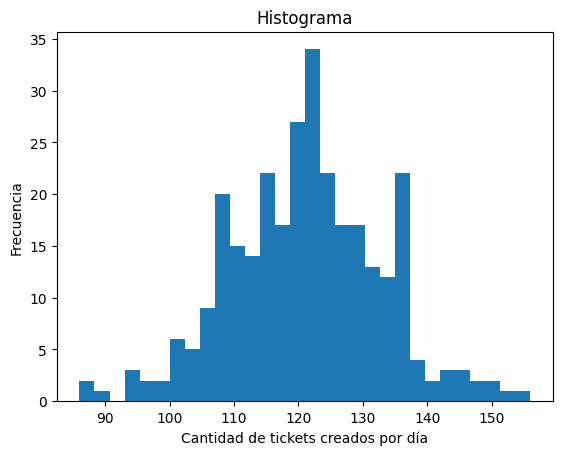

In [ ]:
# Lista tat "cantidad de tickets creados" luego de las 300 réplicas

q_creados_6_6 = [len(i) for i in tat]
print(f'Media               : {np.mean(q_creados_6_6):5.3f}')
print(f'Mediana             : {np.median(q_creados_6_6):5.3f}')
print(f'Desviación estándar : {np.std(q_creados_6_6):5.3f}')


plt.hist(q_creados_6_6, bins=30)
plt.ylabel('Frecuencia')
plt.xlabel('Cantidad de tickets creados por día')
plt.title('Histograma')
plt.show()

####Cantidad de tickets resueltos en un día laboral

Media               : 101.637
Mediana             : 102.000
Desviación estándar : 6.441


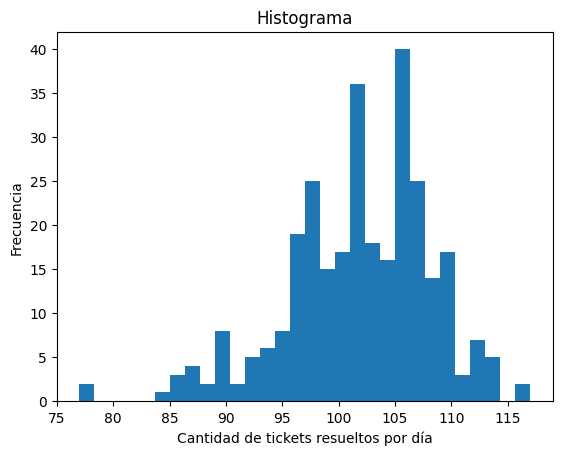

In [ ]:
# Lista tch "cantidad de tickets resueltos" luego de las 300 réplicas

q_resueltos_6_6 = tch
print(f'Media               : {np.mean(q_resueltos_6_6):5.3f}')
print(f'Mediana             : {np.median(q_resueltos_6_6):5.3f}')
print(f'Desviación estándar : {np.std(q_resueltos_6_6):5.3f}')

plt.hist(q_resueltos_6_6, bins=30)
plt.ylabel('Frecuencia')
plt.xlabel('Cantidad de tickets resueltos por día')
plt.title('Histograma')
plt.show()

####Nivel de atención de un día laboral

Media               : 0.844
Mediana             : 0.849
Desviación estándar : 0.054


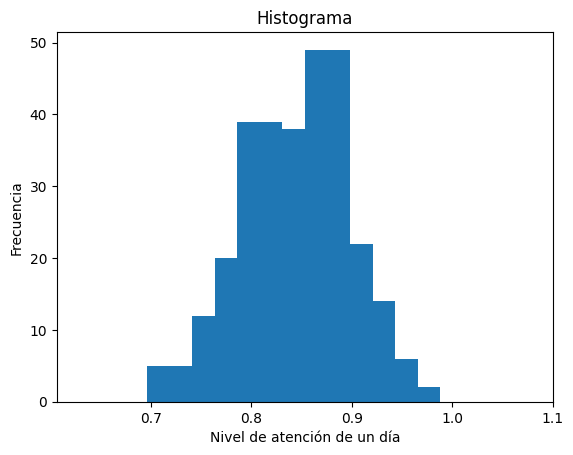

In [ ]:
# Lista tNA "nivel de atención" luego de las 300 réplicas

nivel_atencion_6_6 = tNA
print(f'Media               : {np.mean(nivel_atencion_6_6):5.3f}')
print(f'Mediana             : {np.median(nivel_atencion_6_6):5.3f}')
print(f'Desviación estándar : {np.std(nivel_atencion_6_6):5.3f}')

plt.hist(nivel_atencion_6_6, bins=20, range=(min(nivel_atencion_6_6)*0.9, max(nivel_atencion_6_6)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Nivel de atención de un día')
plt.title('Histograma')
plt.show()

####Leadtime end to end de un día laboral

Media               : 61.682
Mediana             : 58.072
Desviación estándar : 13.914


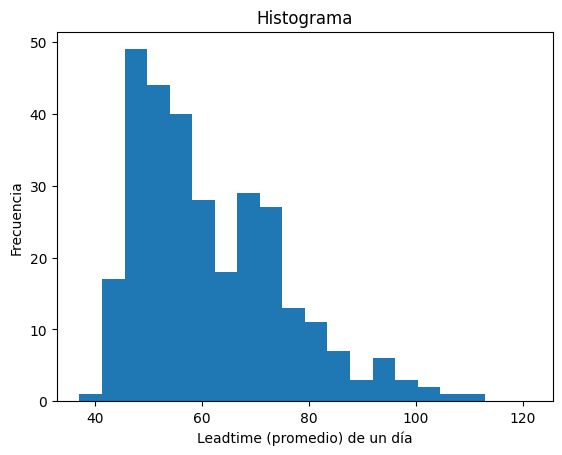

In [ ]:
# Lista tLT "leadtime" luego de las 30 replicas

leadtime_6_6 = tLT
print(f'Media               : {np.mean(leadtime_6_6):5.3f}')
print(f'Mediana             : {np.median(leadtime_6_6):5.3f}')
print(f'Desviación estándar : {np.std(leadtime_6_6):5.3f}')

plt.hist(leadtime_6_6, bins=20, range=(min(leadtime_6_6)*0.9, max(leadtime_6_6)*1.1))
plt.ylabel('Frecuencia')
plt.xlabel('Leadtime (promedio) de un día')
plt.title('Histograma')
plt.show()

####Conclusión

Los resultados muestran una mejora significativa al comparar este escenario (6 + 6) V/S la situación inicial (2 + 2), esto para los 2 indicadores objeto de optimización. A modo de resumen se comparten los boxplots para ambos indicadores.



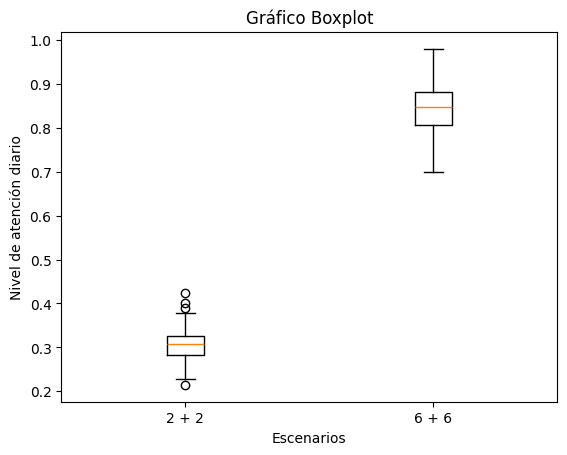

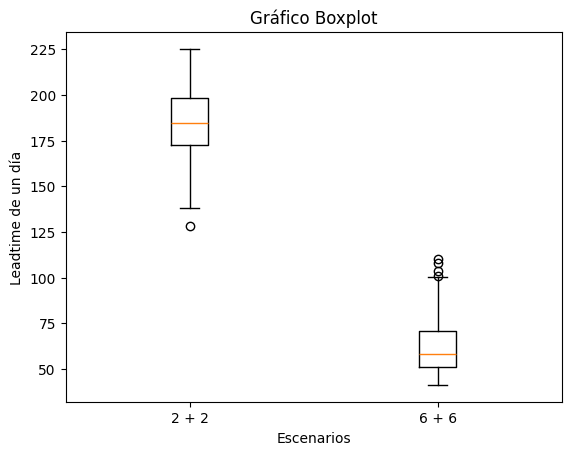

In [ ]:
# Graficar boxplots de nivel de atención

columns_to_plot = [nivel_atencion_2_2, nivel_atencion_6_6]

plt.boxplot(columns_to_plot)
plt.ylabel('Nivel de atención diario')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2],
           ["2 + 2", "6 + 6"])
plt.show()

columns_to_plot = [leadtime_2_2,  leadtime_6_6]

plt.boxplot(columns_to_plot)
plt.ylabel('Leadtime de un día')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2],
           ["2 + 2", "6 + 6"])
plt.show()

Si bien existe una mejora significativa, aún falta mejorar para llegar a las metas planteadas. Por esta razón se continuará con nuevos experimentos, donde primero incorporaremos 1 nueva persona al Help Desk, primero en el proceso N°1 y luego otro experimento donde esta persona adicional se sumará al proceso N°2. Finalmente el último experimento será con 7 personas en el proceso N°1 y 7 en el proceso N°2.

Aquí la configuración:

* Experimento 5:
 * Cantidad agentes en proceso N° 1 = **7**
 * Cantidad agentes en proceso N° 2 = **6**
* Experimento 6:
 * Cantidad agentes en proceso N° 1 = **6**
 * Cantidad agentes en proceso N° 2 = **7**
* Experimento 7:
 * Cantidad agentes en proceso N° 1 = **7**
 * Cantidad agentes en proceso N° 2 = **7**




### <font color='blue'>**Análisis de Resultados Modelo con 13 agentes (7 + 6)**</font>

* Cantidad agentes en proceso N° 1 = **7**
* Cantidad agentes en proceso N° 2 = **6**

####Cantidad de tickets creados en un día laboral


In [ ]:
# Setup e inicio de la simulación con n corridas
print("Iniciando la simulación del Help Desk \n")

# Definimos listas vacias para almacenar la lista de resultados de cada corrida
tch = []
tat = []
tNA = []
tLT = []

# Número de corridas
corridas = 300

t0 = time()
tc = t0
print(f"Se realizan {corridas} corridas de {SIM_TIME} minutos cada una")

np.random.seed(seed=RANDOM_SEED) # Aplica la semilla para los objetos de scipy.stats

for c in trange(corridas):
    # Cada corrida individual, inicializa sus estructuras de captura de datos
    customers_handled = 0
    arrival_times = []   # corresponde al tiempo en que ingresa al Backlog el requerimiento
    wait_times_1 = []    # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que lo comienza a trabajar un agente del proceso #1
    wait_times_2 = []    # corresponde al tiempo transcurrido desde que el agente del proceso #1 finaliza su parte, hasta el agente del proceso #2 comienza su etapa del trabajo
    support_times_1 = [] # corresponde al tiempo transcurrido desde que agente del proceso #1 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    support_times_2 = [] # corresponde al tiempo transcurrido desde que agente del proceso #2 comienza a trabajar el requerimiento hasta que finaliza su etapa del trabajo
    total_times = []     # corresponde al tiempo transcurrido desde que el cliente ingresa un requerimiento (ticket) al HelpDesk hasta que es completamente resuelto

    print(f"\nSIMULACION {c}")

    NUM_EMPLOYEES_1 = 6
    NUM_EMPLOYEES_2 = 7

    # Crea el entorno de simulación e inicia el proceso setup
    env = simpy.Environment()
    env.process(setup(env, NUM_EMPLOYEES_1, NUM_EMPLOYEES_2, SUPPORT_TIME_1, SUPPORT_TIME_2, CUSTOMER_INTERVAL, verbose=False))

    # Ejecuta!
    env.run(until=SIM_TIME)

    print(f"\nClientes atendidos:            {customers_handled}")

    # Respuestas
    NA = customers_handled / len(arrival_times) # Nivel de atención
    print(f"Cantidad de tickets creados:   {len(arrival_times)}") # cantidad tickets creados
    print(f"Cantidad de tickets resueltos: {customers_handled}") # cantidad tickets resueltos
    print(f"Nivel de atención:             {NA:6.4f}") # Nivel atención
    print(f"Leadtime:                      {np.mean(total_times):4.2f}") # leadtime
    tch.append(customers_handled)
    tat.append(arrival_times)
    tNA.append(NA)
    tLT.append(np.mean(total_times))
    print(f"\nTiempo total de simulación {c}: {(time() - tc):4.2f} segundos")
    tc = time()
print(f"\nTiempo total de simulación: {(time() - t0):4.2f} segundos")

Iniciando la simulación del Help Desk 

Se realizan 300 corridas de 480 minutos cada una


  0%|          | 0/300 [00:00<?, ?it/s]


SIMULACION 0

Clientes atendidos:            115
Cantidad de tickets creados:   133
Cantidad de tickets resueltos: 115
Nivel de atención:             0.8647
Leadtime:                      48.77

Tiempo total de simulación 0: 0.03 segundos

SIMULACION 1

Clientes atendidos:            96
Cantidad de tickets creados:   106
Cantidad de tickets resueltos: 96
Nivel de atención:             0.9057
Leadtime:                      44.00

Tiempo total de simulación 1: 0.02 segundos

SIMULACION 2

Clientes atendidos:            116
Cantidad de tickets creados:   134
Cantidad de tickets resueltos: 116
Nivel de atención:             0.8657
Leadtime:                      53.00

Tiempo total de simulación 2: 0.03 segundos

SIMULACION 3

Clientes atendidos:            113
Cantidad de tickets creados:   129
Cantidad de tickets resueltos: 113
Nivel de atención:             0.8760
Leadtime:                      63.00

Tiempo total de simulación 3: 0.02 segundos

SIMULACION 4

Clientes atendidos:        

media :  121.34666666666666
median :  122.0


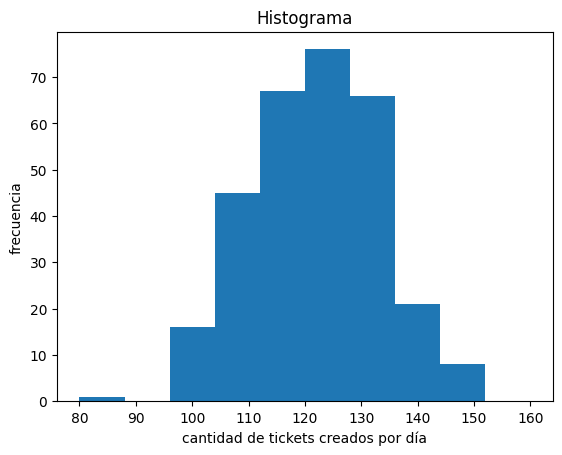

In [ ]:
#dataset "cantidad de tickets creados" luego de las 30 replicas

q_creados_7_6 = [len(i) for i in tat]
print('media : ', np.mean(q_creados_7_6))
print('median : ', np.median(q_creados_7_6))

plt.hist(q_creados_7_6, bins=10, range=(80, 160))
plt.ylabel('frecuencia')
plt.xlabel('cantidad de tickets creados por día')
plt.title('Histograma')
plt.show()

####Cantidad de tickets resueltos en un día laboral

media :  103.23333333333333
median :  103.5


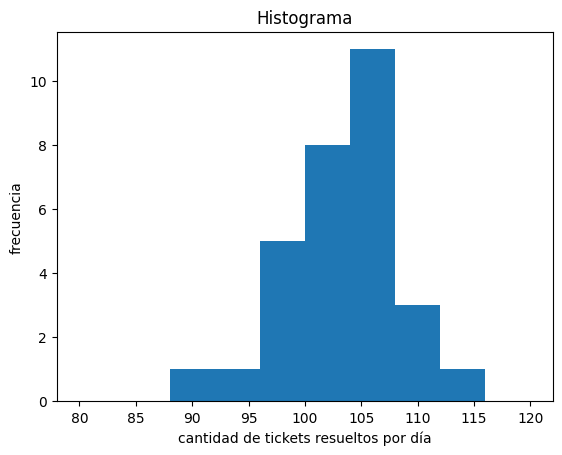

In [ ]:
#dataset "cantidad de tickets resueltos" luego de las 30 replicas

q_resueltos_7_6 = (101,	106,	95,	103,	107,	98,	107,	91,	109,	107,	113,	103,	107,	99,	104,	97,	111,	106,	96,	101,	98,	101,	105,	103,	105,	107,	107,	110,	100,	100)
print('media : ', np.mean(q_resueltos_7_6))
print('median : ', np.median(q_resueltos_7_6))

plt.hist(q_resueltos_7_6, bins=10, range=(80, 120))
plt.ylabel('frecuencia')
plt.xlabel('cantidad de tickets resueltos por día')
plt.title('Histograma')
plt.show()

####Nivel de atención de un día laboral

media :  0.8522997954405713
median :  0.8536874999999999
desv. std :  0.059550009445770095


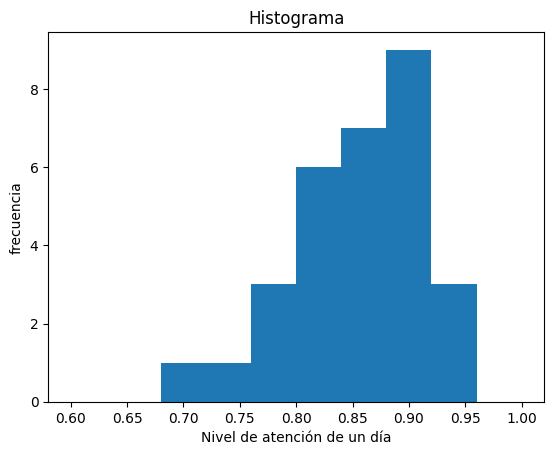

In [ ]:
#dataset "nivel de atención" luego de las 30 replicas

nivel_atencion_7_6 = (0.878260869565217,	0.688311688311688,	0.785123966942148,	0.811023622047244,	0.906779661016949,	0.844827586206896,	0.804511278195488,	0.842592592592592,	0.900826446280991,	0.930434782608695,	0.896825396825396,	0.830645161290322,	0.748251748251748,	0.908256880733945,	0.818897637795275,	0.889908256880733,	0.932773109243697,	0.848,	0.768,	0.870689655172413,	0.907407407407407,	0.841666666666666,	0.897435897435897,	0.88034188034188,	0.954545454545454,	0.8359375,	0.891666666666666,	0.859375,	0.826446280991735,	0.7692307692)
print('media : ', np.mean(nivel_atencion_7_6))
print('median : ', np.median(nivel_atencion_7_6))
print('desv. std : ', np.std(nivel_atencion_7_6))

plt.hist(nivel_atencion_7_6, bins=10, range=(0.6, 1))
plt.ylabel('frecuencia')
plt.xlabel('Nivel de atención de un día')
plt.title('Histograma')
plt.show()

####Leadtime end to end de un día laboral

media :  62.947087538403395
median :  58.85551411218595
desv. std :  14.278202691447657


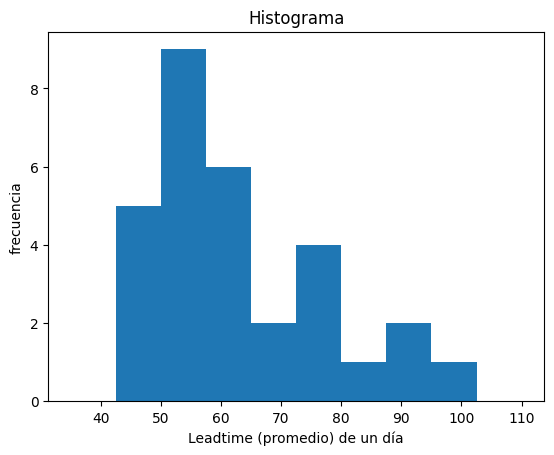

In [ ]:
#dataset "leadtime" luego de las 30 replicas

leadtime_7_6 = (49.1583700819085,	99.0533526345536,	61.7102852322823,	82.0716740199001,	75.8669605798243,	58.9988543359881,	91.7117890817056,	47.9534404529701,	63.0071097367501,	50.0256823940301,	47.9709323379706,	64.4313735298912,	76.4917384357869,	44.8833550228611,	55.0968182281751,	56.8770522018284,	65.5131876839091,	73.9362035659634,	79.8549101663167,	46.5015064883481,	52.5896192016395,	52.3636933077031,	50.5158797155093,	56.374835893221,	51.894337294223,	58.7121738883838,	65.2399701292719,	56.4945455351782,	63.1323334660087,	89.98064151)
print('media : ', np.mean(leadtime_7_6))
print('median : ', np.median(leadtime_7_6))
print('desv. std : ', np.std(leadtime_7_6))

plt.hist(leadtime_7_6, bins=10, range=(35, 110))
plt.ylabel('frecuencia')
plt.xlabel('Leadtime (promedio) de un día')
plt.title('Histograma')
plt.show()

####Conclusiones
Este escenario que adiciona una nueva persona al Help Desk (al primer proceso), no genera resultados muy diferentes al escenario con 6 y 6 agentes visto anteriormente, y en consecuencia tampoco vemos cumplimiento del target trazado por el negocio.

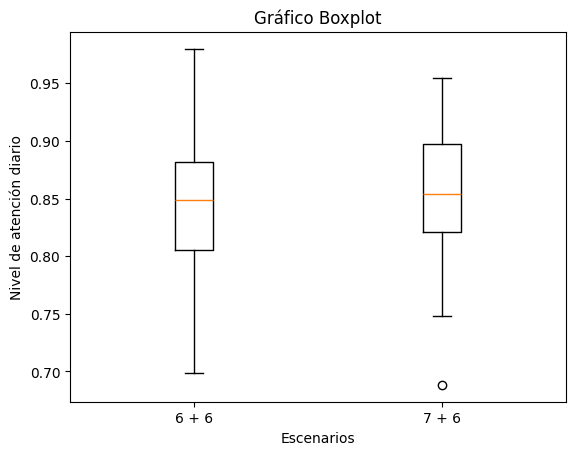

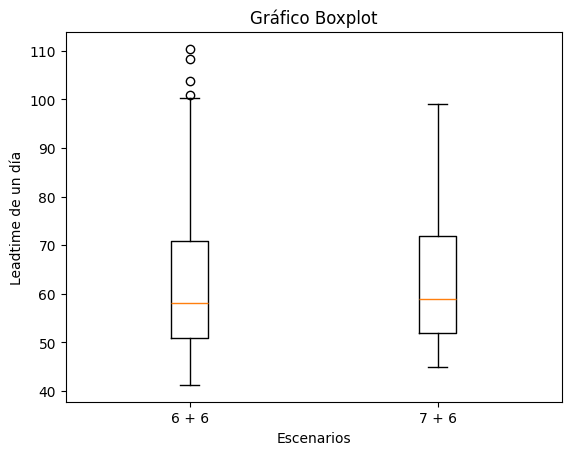

In [ ]:
#Graficar boxplots de nivel de atención

columns_to_plot = [nivel_atencion_6_6, nivel_atencion_7_6]

plt.boxplot(columns_to_plot)
plt.ylabel('Nivel de atención diario')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2],
           ["6 + 6", "7 + 6"])
plt.show()

columns_to_plot = [leadtime_6_6,  leadtime_7_6]

plt.boxplot(columns_to_plot)
plt.ylabel('Leadtime de un día')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2],
           ["6 + 6", "7 + 6"])
plt.show()

Si quisiéramos calcular la probabilidad de cumplir el target en nivel de atención y en leadtime, podríamos hacerlo con el siguiente código:

In [ ]:
#nivel de atención
target_na= 0.85
prob_mayor_85 = stats.norm(np.mean(nivel_atencion_7_6), np.std(nivel_atencion_7_6)).sf(target_na)
print('Prob cumplir target Nivel de atención: ',prob_mayor_85)


#Leadtime
target_lt= 60
prob_menor_60 = stats.norm(np.mean(leadtime_7_6), np.std(leadtime_7_6)).cdf(target_lt)
print('Prob cumplir target Nivel de atención: ',prob_menor_60)

Prob cumplir target Nivel de atención:  0.5154031482093854
Prob cumplir target Nivel de atención:  0.4182374164430283


La probabilidad es muy baja, debemos seguir iterando con otro escenario.

### <font color='blue'>**Análisis de Resultados Modelo con 13 agentes (6 + 7)**</font>

* Cantidad agentes en proceso N° 1 = **6**
* Cantidad agentes en proceso N° 2 = **7**

####Cantidad de tickets creados en un día laboral

media :  121.26666666666667
median :  121.5


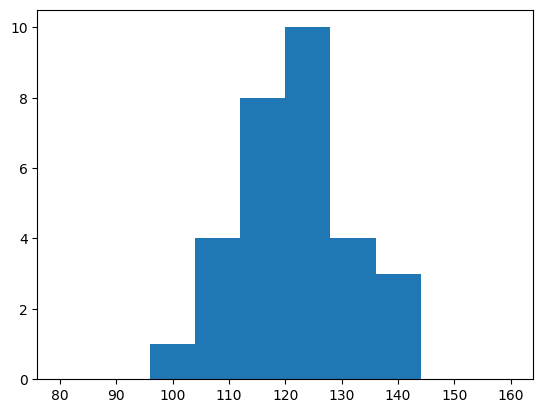

In [ ]:
#dataset "cantidad de tickets creados" luego de las 30 replicas

q_creados_6_7 = (135,	114,	130,	139,	117,	109,	96,	110,	123,	127,	133,	126,	115,	125,	127,	114,	121,	109,	124,	138,	115,	113,	110,	113,	134,	121,	122,	123,	138,	117)
print('media : ', np.mean(q_creados_6_7))
print('median : ', np.median(q_creados_6_7))

plt.hist(q_creados_6_7, bins=10, range=(80, 160))
plt.show()

####Cantidad de tickets resueltos en un día laboral

media :  107.56666666666666
median :  107.5


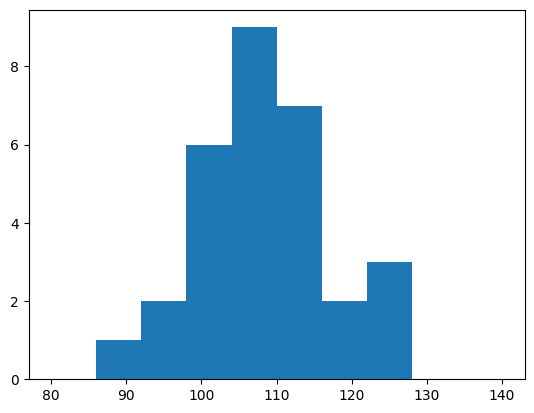

In [ ]:
#dataset "cantidad de tickets resueltos" luego de las 30 replicas

q_resueltos_6_7 = (122,	103,	116,	120,	108,	99,	88,	97,	112,	110,	115,	110,	104,	109,	115,	97,	107,	98,	110,	122,	108,	101,	100,	104,	112,	102,	106,	105,	122,	105)
print('media : ', np.mean(q_resueltos_6_7))
print('median : ', np.median(q_resueltos_6_7))

plt.hist(q_resueltos_6_7, bins=10, range=(80, 140))
plt.show()

####Nivel de atención de un día laboral

media :  0.8879829934903113
median :  0.88970223325062
desv. std :  0.02468018420139606


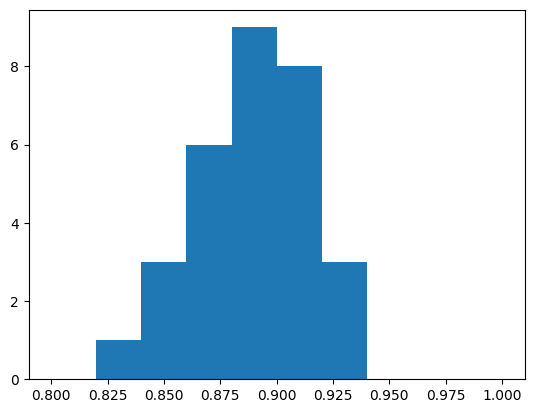

In [ ]:
#dataset "nivel de atención" luego de las 30 replicas

nivel_atencion_6_7 = (0.903703703703703,	0.903508771929824,	0.892307692307692,	0.863309352517985,	0.923076923076923,	0.908256880733945,	0.916666666666666,	0.881818181818181,	0.910569105691056,	0.866141732283464,	0.864661654135338,	0.873015873015873,	0.904347826086956,	0.872,	0.905511811023622,	0.850877192982456,	0.884297520661157,	0.899082568807339,	0.887096774193548,	0.884057971014492,	0.939130434782608,	0.893805309734513,	0.909090909090909,	0.920353982300884,	0.835820895522388,	0.84297520661157,	0.868852459016393,	0.853658536585365,	0.884057971014492,	0.8974358974)
print('media : ', np.mean(nivel_atencion_6_7))
print('median : ', np.median(nivel_atencion_6_7))
print('desv. std : ', np.std(nivel_atencion_6_7))

plt.hist(nivel_atencion_6_7, bins=10, range=(0.8, 1))
plt.show()

####Leadtime end to end de un día laboral

media :  48.15055526410494
median :  46.8647355642982
desv. std :  4.244337367479355


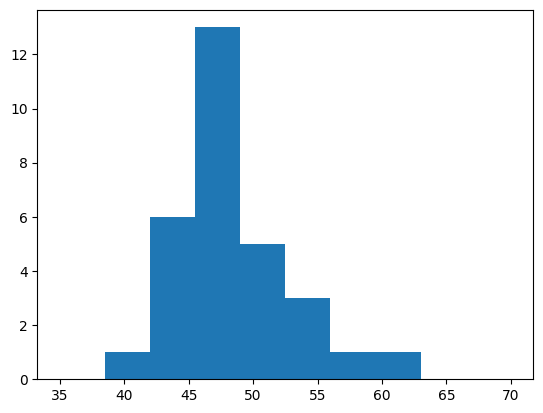

In [ ]:
#dataset "leadtime" luego de las 30 replicas

leadtime_6_7 = (53.1975596318308,	49.0244255473882,	56.4567660607805,	62.315738496735,	47.4281121105065,	46.6693427385964,	41.9643835213676,	49.8300003236978,	45.3129103834484,	46.2416443983409,	54.8283574717164,	45.0278871046012,	46.4974472088699,	47.1194241680025,	49.210585830925,	42.9706044889407,	45.220848756284,	44.3338572635864,	45.9869260692168,	47.7193533971424,	51.6963373720519,	45.9063969156246,	45.7106181342354,	45.9948574833915,	49.4042514184657,	45.8652389578306,	44.8065634654348,	47.3734979407537,	53.3425928733828,	47.06012839)
print('media : ', np.mean(leadtime_6_7))
print('median : ', np.median(leadtime_6_7))
print('desv. std : ', np.std(leadtime_6_7))

plt.hist(leadtime_6_7, bins=10, range=(35, 70))
plt.show()

####Conclusiones

Este escenario que adiciona una nueva persona al Help Desk (al segundo proceso), vemos que si genera resultados diferentes al escenario con 6 y 6 agentes visto anteriormente. Estos resultados se acercan y calzan muy bien con las metas trazadas.

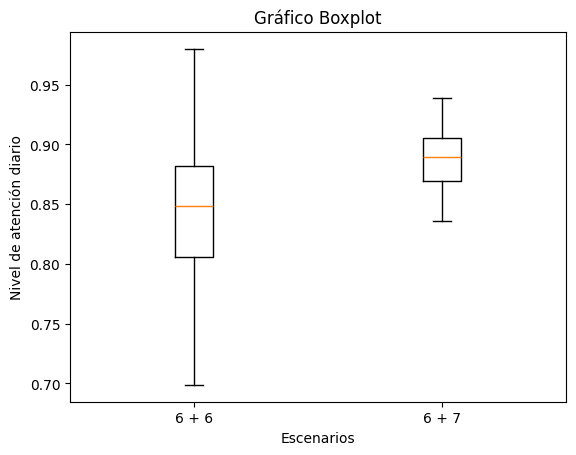

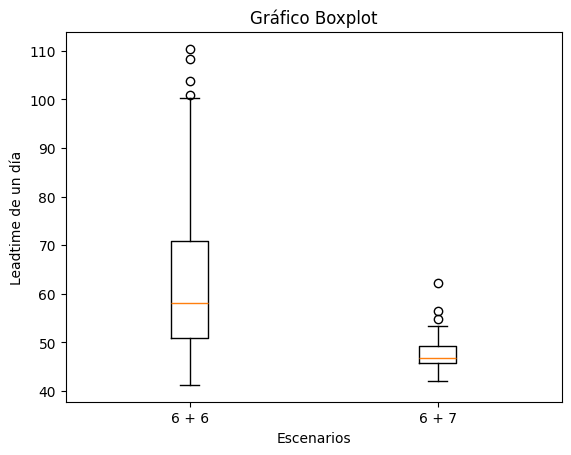

In [ ]:
#Graficar boxplots de nivel de atención

columns_to_plot = [nivel_atencion_6_6, nivel_atencion_6_7]

plt.boxplot(columns_to_plot)
plt.ylabel('Nivel de atención diario')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2],
           ["6 + 6", "6 + 7"])
plt.show()

columns_to_plot = [leadtime_6_6,  leadtime_6_7]

plt.boxplot(columns_to_plot)
plt.ylabel('Leadtime de un día')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2],
           ["6 + 6", "6 + 7"])
plt.show()

Si quisiéramos calcular la probabilidad de cumplir el target en nivel de atención y en leadtime, podríamos hacerlo con el siguiente código:

In [ ]:
#nivel de atención
target_na= 0.85
prob_mayor_85 = stats.norm(np.mean(nivel_atencion_6_7), np.std(nivel_atencion_6_7)).sf(target_na)
print('Prob cumplir target Nivel de atención: ',prob_mayor_85)


#Leadtime
target_lt= 60
prob_menor_60 = stats.norm(np.mean(leadtime_6_7), np.std(leadtime_6_7)).cdf(target_lt)
print('Prob cumplir target Leadtime: ',prob_menor_60)

Prob cumplir target Nivel de atención:  0.9380987916114423
Prob cumplir target Leadtime:  0.9973794106642423


Una buena seguridad es de 85% o 90%, en este caso ambos cuentan con una probabilidad de cumplirse sobre 90%.


De todas formas haremos el último experimento, tomaremos este escenario óptimo (6 + 7) y le incorporaremos una nueva persona, pero ahora al primer proceso de tal forma de tener 7 y 7 agentes, veamos si genera una mejora.

### <font color='blue'>**Análisis de Resultados Modelo con 14 agentes (7 + 7)**</font>

* Cantidad agentes en proceso N° 1 = **7**
* Cantidad agentes en proceso N° 2 = **7**

####Cantidad de tickets creados en un día laboral

media :  120.0
median :  119.0


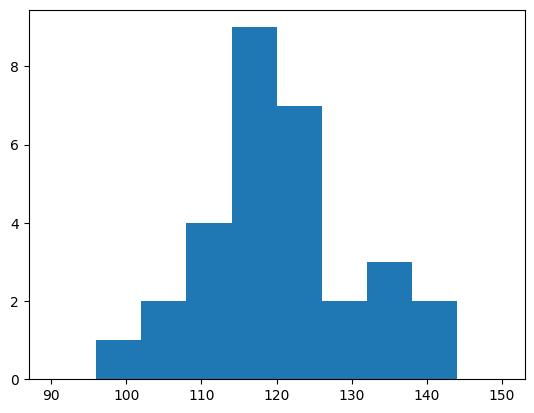

In [ ]:
#dataset "cantidad de tickets creados" luego de las 30 replicas

q_creados_7_7 = (105,	125,	119,	108,	126,	127,	121,	115,	142,	118,	112,	143,	108,	117,	132,	117,	125,	120,	117,	119,	100,	113,	118,	120,	104,	123,	124,	134,	133,	115)
print('media : ', np.mean(q_creados_7_7))
print('median : ', np.median(q_creados_7_7))

plt.hist(q_creados_7_7, bins=10, range=(90, 150))
plt.show()

####Cantidad de tickets resueltos en un día laboral

media :  105.1
median :  105.5


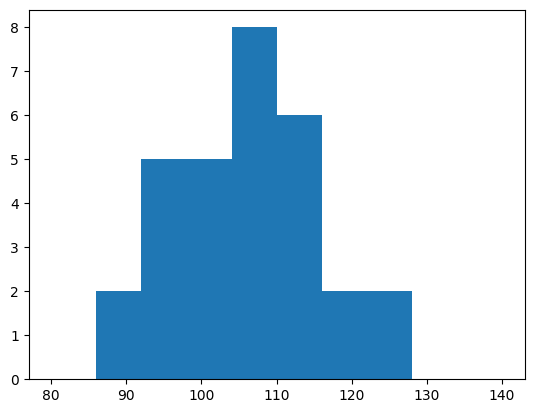

In [ ]:
#dataset "cantidad de tickets resueltos" luego de las 30 replicas

q_resueltos_7_7 = (96,	111,	111,	100,	111,	110,	104,	108,	122,	97,	92,	125,	96,	101,	116,	103,	105,	106,	98,	106,	87,	99,	110,	107,	90,	107,	105,	121,	113,	96)
print('media : ', np.mean(q_resueltos_7_7))
print('median : ', np.median(q_resueltos_7_7))

plt.hist(q_resueltos_7_7, bins=10, range=(80, 140))
plt.show()

####Nivel de atención de un día laboral

media :  0.8761955063551514
median :  0.8751160344080695
desv. std :  0.03100813690943246


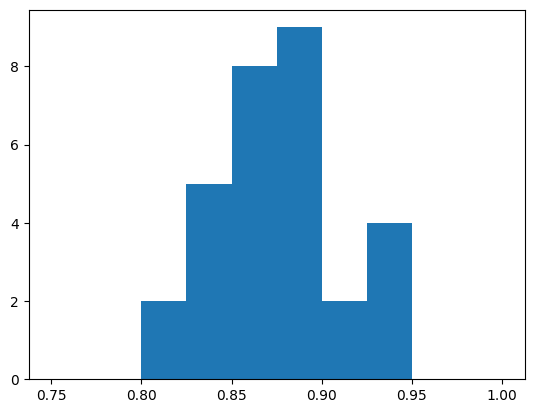

In [ ]:
#dataset "nivel de atención" luego de las 30 replicas

nivel_atencion_7_7 = (0.914285714285714,	0.888,	0.932773109243697,	0.925925925925925,	0.88095238095238,	0.866141732283464,	0.859504132231405,	0.939130434782608,	0.859154929577464,	0.822033898305084,	0.821428571428571,	0.874125874125874,	0.888888888888888,	0.863247863247863,	0.878787878787878,	0.88034188034188,	0.84,	0.883333333333333,	0.837606837606837,	0.890756302521008,	0.87,	0.876106194690265,	0.932203389830508,	0.891666666666666,	0.865384615384615,	0.869918699186991,	0.846774193548387,	0.902985074626865,	0.849624060150376,	0.8347826087)
print('media : ', np.mean(nivel_atencion_7_7))
print('median : ', np.median(nivel_atencion_7_7))
print('desv. std : ', np.std(nivel_atencion_7_7))

plt.hist(nivel_atencion_7_7, bins=10, range=(0.75, 1))
plt.show()

####Leadtime end to end de un día laboral

media :  49.00685479740911
median :  46.97784535112485
desv. std :  6.123806425763224


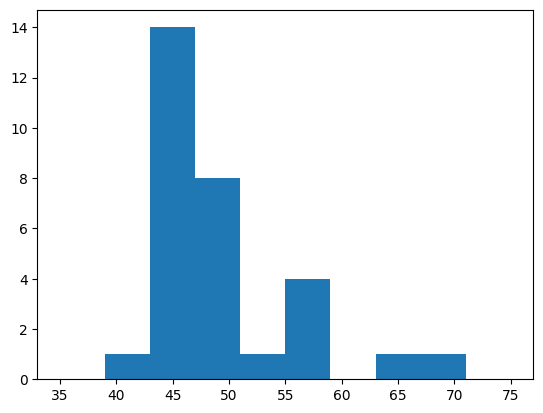

In [ ]:
#dataset "leadtime" luego de las 30 replicas

leadtime_7_7 = (43.322609896691,	47.084180425769,	45.7720978324494,	46.156849988107,	46.6197117347084,	57.2581328874476,	56.0493584196893,	45.6947766761175,	56.532099201808,	48.0833235558764,	47.7781348669569,	48.4721537127348,	45.5728938345168,	51.8554585602254,	55.4767600336189,	48.3963766899343,	45.5228953511932,	47.6058706796067,	44.3303444366427,	44.9878699944936,	45.7933292366337,	45.1188994440432,	43.6738025569844,	47.9401518730451,	41.117363422725,	46.8715102764807,	47.0931850707286,	68.2184092771946,	65.1999877058515,	46.60710628)
print('media : ', np.mean(leadtime_7_7))
print('median : ', np.median(leadtime_7_7))
print('desv. std : ', np.std(leadtime_7_7))

plt.hist(leadtime_7_7, bins=10, range=(35, 75))
plt.show()

####Conclusiones

Al comparar los resultados de este escenario (7+7) V/S el escenario óptimo anterior con 6 + 7 agentes, no vemos diferencias. Por un tema de eficiencia recomendamos el escenario con 6 + 7 agentes.

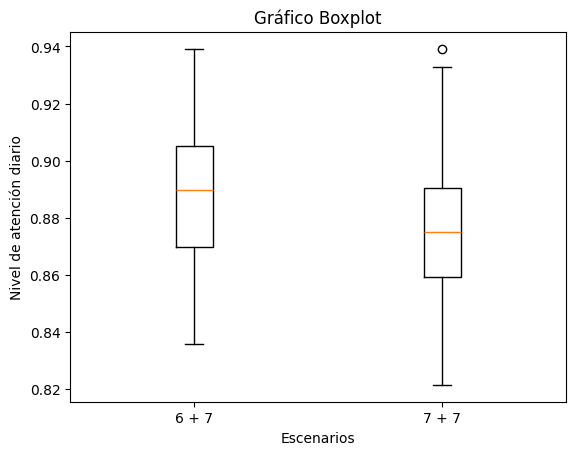

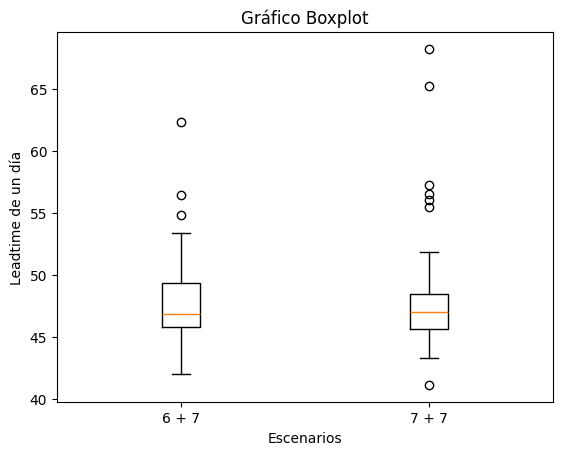

In [ ]:
#Graficar boxplots de nivel de atención

columns_to_plot = [nivel_atencion_6_7, nivel_atencion_7_7]

plt.boxplot(columns_to_plot)
plt.ylabel('Nivel de atención diario')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2],
           ["6 + 7", "7 + 7"])
plt.show()

columns_to_plot = [leadtime_6_7,  leadtime_7_7]

plt.boxplot(columns_to_plot)
plt.ylabel('Leadtime de un día')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2],
           ["6 + 7", "7 + 7"])
plt.show()

Al calcular la probabilidad de cumplir target vemos que este escenario tiene menos capacidad que el anterior con 6 + 7 agentes.

In [ ]:
#nivel de atención
target_na= 0.85
prob_mayor_85 = stats.norm(np.mean(nivel_atencion_7_7), np.std(nivel_atencion_7_7)).sf(target_na)
print('Prob cumplir target Nivel de atención: ',prob_mayor_85)


#Leadtime
target_lt= 60
prob_menor_60 = stats.norm(np.mean(leadtime_7_7), np.std(leadtime_7_7)).cdf(target_lt)
print('Prob cumplir target Leadtime: ',prob_menor_60)

Prob cumplir target Nivel de atención:  0.8008872325810505
Prob cumplir target Leadtime:  0.9636850210964173


A continuación un resumen con todos los escenarios desarrollados:

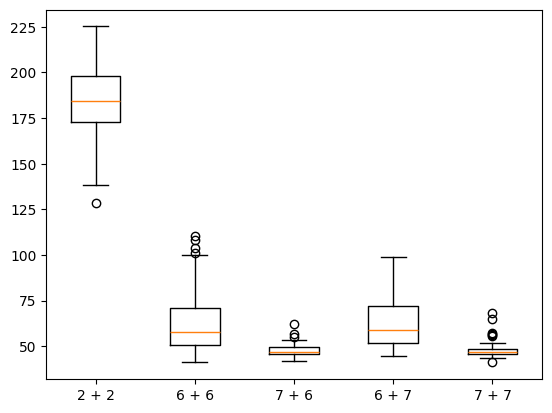

In [ ]:
#Boxplot resumen
columns_to_plot = [leadtime_2_2, leadtime_6_6, leadtime_6_7, leadtime_7_6, leadtime_7_7]
plt.boxplot(columns_to_plot)
plt.xticks([1, 2, 3 , 4, 5],
           ["2 + 2", "6 + 6", "7 + 6", "6 + 7", "7 + 7"])
plt.show()

La invitación es a seguir planteando hipótesis y a crear experimentos, por ejemplo:

* ¿qué pasa sí trabajamos con un modelo con 5 + 7 agentes?
* ¿qué pasa si al modelo con 6 + 6 agentes al proceso N°2 le aplicamos una mejora que reduzca la media de ese proceso en 2 minutos ?

o esta que procederé a testear:
* ¿qué pasa sí el proceso ahora es más Lean, es decir los agentes tendrán la habilidad de desarrollar de forma autónoma tanto el proceso N°1 como el N°2, es decir, sin tener especialista por proceso, y así evitar dependencias ?


Para esta última idea procederé a crear un nuevo modelo donde los agentes trabajan de punta a punta (end to ened) los requerimientos, mantendré la misma variabilidad en el arribo de requerimientos y en los tiempos de proceso N°1 y proceso N°2, pero comenzaré con 10 agentes en el Help Desk.

### <font color='blue'>**Análisis de Resultados Modelo Lean con 10 agentes**</font>

* Cantidad agentes en sistema: 10 (multi-skill)

####Cantidad de tickets creados en un día laboral

media :  117.33333333333333
median :  118.0


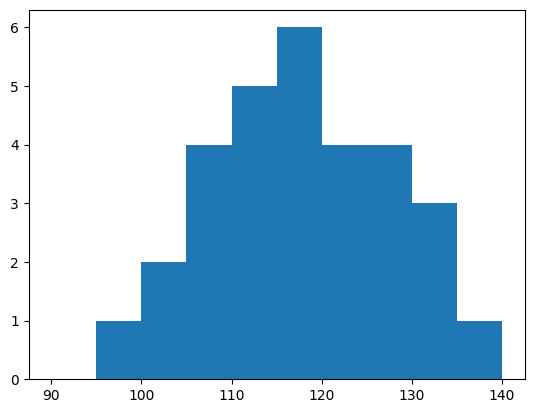

In [ ]:
#dataset "cantidad de tickets creados" luego de las 30 replicas

q_creados_10 = (125,	121,	127,	118,	111,	114,	118,	117,	129,	97,	132,	119,	101,	113,	102,	125,	132,	111,	130,	108,	120,	118,	123,	107,	118,	138,	109,	105,	111,	121)
print('media : ', np.mean(q_creados_10))
print('median : ', np.median(q_creados_10))

plt.hist(q_creados_10, bins=10, range=(90, 140))
plt.show()

####Cantidad de tickets resueltos en un día laboral

media :  98.3
median :  99.5


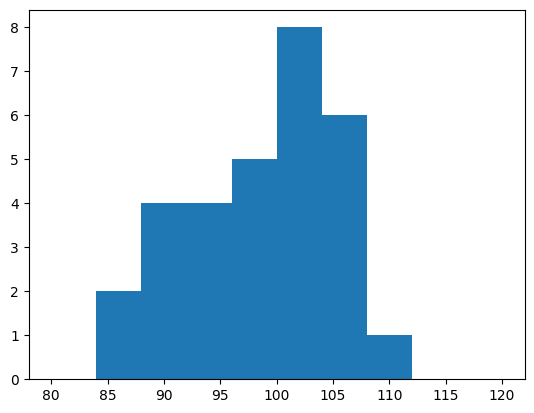

In [ ]:
#dataset "cantidad de tickets resueltos" luego de las 30 replicas

q_resueltos_10 = (101,	107,	99,	101,	96,	92,	98,	103,	106,	90,	102,	87,	90,	98,	87,	107,	107,	104,	100,	96,	103,	93,	110,	90,	102,	102,	92,	93,	89,	104)
print('media : ', np.mean(q_resueltos_10))
print('median : ', np.median(q_resueltos_10))

plt.hist(q_resueltos_10, bins=10, range=(80, 120))
plt.show()

####Nivel de atención de un día laboral

media :  0.8404431102981236
median :  0.8544366899302089
desv. std :  0.050622571980637056


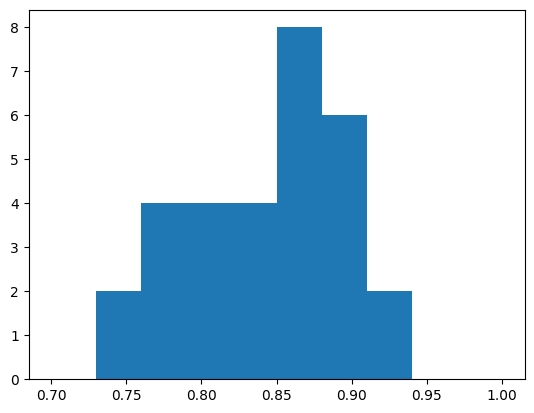

In [ ]:
#dataset "nivel de atención" luego de las 30 replicas

nivel_atencion_10 = (0.808,	0.884297520661157,	0.779527559055118,	0.85593220338983,	0.864864864864864,	0.807017543859649,	0.830508474576271,	0.88034188034188,	0.821705426356589,	0.927835051546391,	0.772727272727272,	0.731092436974789,	0.891089108910891,	0.867256637168141,	0.852941176470588,	0.856,	0.81060606060606,	0.936936936936936,	0.769230769230769,	0.888888888888888,	0.858333333333333,	0.788135593220339,	0.89430894308943,	0.841121495327102,	0.864406779661017,	0.739130434782608,	0.844036697247706,	0.885714285714285,	0.801801801801801,	0.8595041322)
print('media : ', np.mean(nivel_atencion_10))
print('median : ', np.median(nivel_atencion_10))
print('desv. std : ', np.std(nivel_atencion_10))

plt.hist(nivel_atencion_10, bins=10, range=(0.7, 1))
plt.show()

####Leadtime end to end de un día laboral

media :  59.10315398786601
median :  57.4955361467393
desv. std :  10.692881202693417


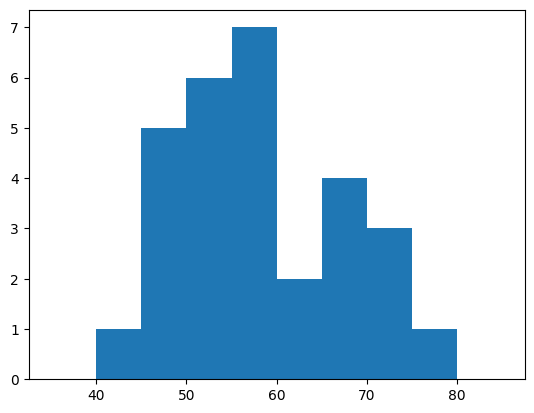

In [ ]:
#dataset "leadtime" luego de las 30 replicas

leadtime_10 = (53.1863054978049,	53.2612969324382,	71.7309401026294,	58.9759604216758,	47.7658880298651,	61.026104922349,	57.7298706680236,	51.6020378434249,	71.9253073663495,	50.5544056907006,	67.5954012027775,	67.4082744127459,	57.261201625455,	56.7830632757687,	55.779709150814,	50.3577318585442,	77.3067153144377,	46.0836769224701,	66.5089683243229,	48.2067916324666,	91.5704616969531,	53.6056626704019,	61.4775914821813,	47.3216918687722,	70.8206745562992,	68.233277248549,	47.1540420928041,	42.7090659519467,	59.1570735330091,	59.99542734)
print('media : ', np.mean(leadtime_10))
print('median : ', np.median(leadtime_10))
print('desv. std : ', np.std(leadtime_10))

plt.hist(leadtime_10, bins=10, range=(35, 85))
plt.show()

####Conclusiones

Al analizar los resultados de este escenario, vemos que no cumple de buena forma el target planteado, pero podemos darnos cuenta que sus resultados son muy similares al escenario con procesos especializados con 6 + 6 agentes. La diferencia aquí radica en los costos asociados, ya que este escenario tendría los mismos resultados que el modelo con 12 agentes (6 + 6) pero con menores costos, aproximadamente un 17% menos.








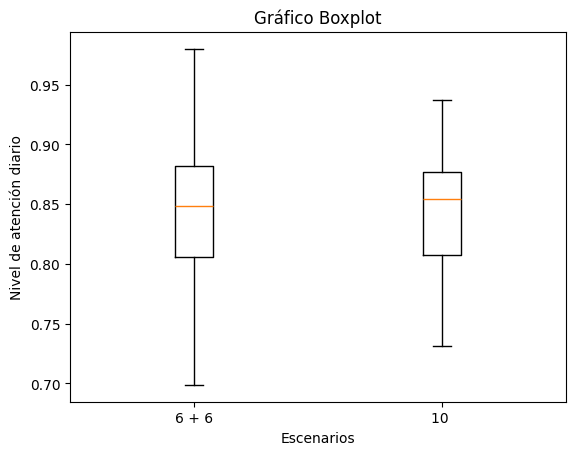

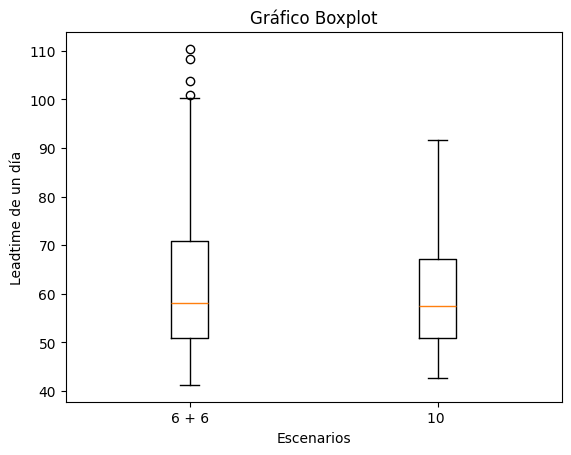

In [ ]:
#Graficar boxplots de nivel de atención

columns_to_plot = [nivel_atencion_6_6, nivel_atencion_10]

plt.boxplot(columns_to_plot)
plt.ylabel('Nivel de atención diario')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2],
           ["6 + 6", "10 "])
plt.show()

columns_to_plot = [leadtime_6_6,  leadtime_10]

plt.boxplot(columns_to_plot)
plt.ylabel('Leadtime de un día')
plt.xlabel('Escenarios')
plt.title('Gráfico Boxplot')
plt.xticks([1, 2],
           ["6 + 6", "10 "])
plt.show()

Tendríamos que probar otro escenario con 11 agentes en modo lean y ver si cumple el target.

In [ ]:
###Escriba aquí los resultados de su experimento
#

## <font color='blue'>**Cierre**</font>

Para concluir, es importante recordar que este ejercicio es simplemente un ejemplo introductorio de simulación estocástica utilizando SimPy. Hay varios factores aleatorios que no se han incluido en el modelo de simulación, y muchas respuestas interesantes aún por explorar, como la utilización, productividad, ingresos generados por ticket finalizado, premios, multas y otros aspectos.

Esperamos que este ejercicio haya proporcionado un valor significativo y te motive a poner en práctica los conceptos aprendidos. Puedes experimentar ejecutando nuevos escenarios, generando más réplicas de la simulación o adaptándola a diferentes desafíos y casos de uso. Solo necesitas una plataforma como Colab para realizar estas exploraciones a tu propio ritmo.

Mediante la programación en Python, como se ha demostrado en este notebook, tienes acceso a una amplia gama de herramientas matemáticas y estadísticas poderosas. La incorporación de SimPy para la simulación discreta agrega un valioso conjunto de capacidades. Este toolkit conjunto brinda una base sólida para abordar problemas complejos y tomar decisiones informadas.



<img src="https://drive.google.com/uc?export=view&id=1Igtn9UXg6NGeRWsqh4hefQUjV0hmzlBv" width="50" align="left" title="Runa-perth">
<br clear="left">